In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import catboost
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb
from lightgbm import LGBMClassifier
import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

#### Вспомогательные функции

In [2]:
def draw_histogram(column, figsize=None, ylim=None):
    if figsize:
        plt.figure(figsize=figsize)
    else: plt.figure()

    value_counts = df[column].value_counts()
    value_counts.plot(kind='bar')

    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.ylabel('Количество')
    plt.show()

In [3]:
def draw_histogram_categorical(column, target='Depression', figsize=None, ylim=None, min_count=None):
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure()

    grouped = df.groupby([column, target]).size().unstack(fill_value=0)
    grouped = grouped.reindex(columns=sorted(df[target].unique())) 

    if min_count is not None:
        category_counts = grouped.sum(axis=1)
        grouped = grouped[category_counts > min_count]

    nan_count = df[column].isna().sum()
    if nan_count > 0:
        grouped.loc['NaN'] = [nan_count, 0]

    bottom = None
    for target_class, color in zip(grouped.columns, ['blue', 'red']):
        plt.bar(grouped.index, grouped[target_class], bottom=bottom, label=f'Class {target_class}', color=color)
        if bottom is None:
            bottom = grouped[target_class]
        else:
            bottom += grouped[target_class]

    if ylim:
        plt.ylim(ylim[0], ylim[1])

    plt.ylabel('Количество')
    plt.xlabel(column)
    plt.xticks(rotation=90)
    plt.legend(title=target)
    plt.title(f'Гистограмма для {column} с распределением классов')
    plt.show()

In [97]:
def draw_histogram_numeric(column, target='Depression', bins=10, figsize=None, ylim=None, min_count=None):
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure()

    bin_edges = np.linspace(df[column].min(), df[column].max(), bins + 1)
    df['bin'] = pd.cut(df[column], bins=bin_edges, include_lowest=True)

    nan_rows = df[df[column].isna()]

    grouped = df.groupby(['bin', target]).size().unstack(fill_value=0)
    grouped = grouped.reindex(columns=sorted(df[target].unique()))

    if not nan_rows.empty:
        nan_grouped = nan_rows.groupby(target).size()
        nan_row = pd.DataFrame({class_name: [nan_grouped.get(class_name, 0)] for class_name in grouped.columns}, index=['NaN'])
        grouped = pd.concat([grouped, nan_row])

    if min_count is not None:
        category_counts = grouped.sum(axis=1)
        grouped = grouped[category_counts > min_count]

    bottom = None
    colors = ['blue', 'red']
    for target_class, color in zip(grouped.columns, colors):
        plt.bar(grouped.index.astype(str), grouped[target_class], bottom=bottom, label=f'Class {target_class}', color=color)
        if bottom is None:
            bottom = grouped[target_class]
        else:
            bottom += grouped[target_class]

    if ylim:
        plt.ylim(ylim[0], ylim[1])

    plt.ylabel('Количество')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.legend(title=target)
    plt.title(f'Гистограмма для {column} с распределением классов')
    plt.show()
    df.drop(columns=['bin'], inplace=True)


In [113]:
def show_metrics(y_test, y_pred, y_pred_proba=None):
    print(f'Размер проверочного датасета: {len(y_test)}')
    
   # y_pred_proba = model.predict_proba(X_test)[:, 1]
   # y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precis = precision_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    recal = recall_score(y_test, y_pred)
    
    print(f'Accuracy: {acc:.6f}')
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'ROC-AUC: {roc_auc:.6f}')
    print(f'F1 Score: {f1score:.6f}')
    print(f'Precision: {precis:.6f}')
    print(f'Recall: {recal:.6f}')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)  
    plt.show()

In [318]:
def majority_vote_with_metrics(models, X_test, y_test, lgbm=False):
    print(f'Размер проверочного датасета: {len(y_test)}')
    if lgbm:
        y_pred_proba = np.array([lgb_model.predict(X_test) for model in models])
        y_pred = np.array([[1 if pred >= 0.5 else 0 for pred in subarr] for subarr in y_pred_proba])
        y_pred = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=y_pred)
    else:
        predictions = np.array([model.predict(X_test) for model in models])
        y_pred = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)

    acc = accuracy_score(y_test, y_pred)
    precis = precision_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    recal = recall_score(y_test, y_pred)
    
    print(f'Accuracy: {acc:.6f}')
    print(f'F1 Score: {f1score:.6f}')
    print(f'Precision: {precis:.6f}')
    print(f'Recall: {recal:.6f}')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)  
    plt.show()
    return y_pred

In [43]:
def submit_predictions(predictions, filename):
    predictions_df = pd.DataFrame({
        'id': np.arange(140700, 234499 + 1),
        'Depression': predictions
    })
    predictions_df.to_csv(f'{filename}.csv', index=False)
    print(f'Файл {filename}.csv сохранен.')


# Первичная обработка и анализ данных

In [4]:
df = pd.read_csv('train.csv')
target = 'Depression'
labels = df[target]
df

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0
140698,140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No,0


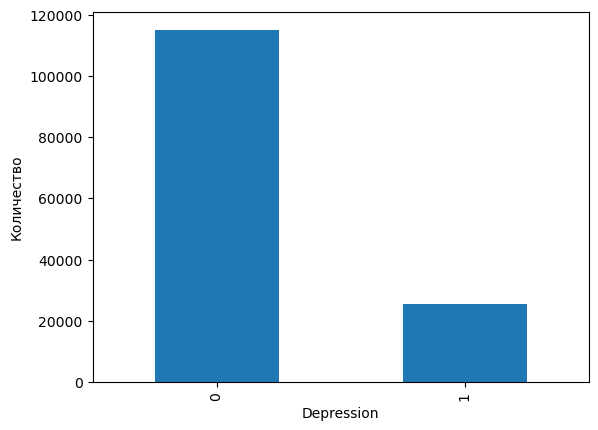

In [72]:
draw_histogram(target)

In [102]:
class_0 = df[df[target] == 0]
class_1 = df[df[target] == 1]
print(f'Количество объектов с классом 0: {len(class_0)}')
print(f'Количество объектов с классом 1: {len(class_1)}')
print(f'Соотношение классов (1 к 0): {(len(class_1) / len(class_0)):.4f}') 

Количество объектов с классом 0: 115133
Количество объектов с классом 1: 25567
Соотношение классов (1 к 0): 0.2221


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   City                                   140700 non-null  object 
 3   Working Professional or Student        140700 non-null  object 
 4   Profession                             104070 non-null  object 
 5   Academic Pressure                      27897 non-null   float64
 6   Work Pressure                          112782 non-null  float64
 7   CGPA                                   27898 non-null   float64
 8   Study Satisfaction                     27897 non-null   float64
 9   Job Satisfaction                       112790 non-null  float64
 10  Sleep Duration                         140700 non-null  

In [18]:
df.isna().sum()

Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [5]:
num_cols = list(df.select_dtypes(include=[int, float]).columns)
print('Числовые столбцы:', (num_cols))

cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)
print('Категориальные столбцы:', (cat_cols))

Числовые столбцы: ['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']
Категориальные столбцы: ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


## Анализ данных

### **Категориальные данные**

Практическив каждом столбце с категориальными данными встречаются некорректные данные, не относящиеся к характеристике. 

In [103]:
df[cat_cols].isna().sum()

Name                                         0
Gender                                       0
City                                         0
Working Professional or Student              0
Profession                               36630
Sleep Duration                               0
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
Family History of Mental Illness             0
dtype: int64

In [7]:
df[cat_cols].nunique()

Gender                                    2
City                                     68
Working Professional or Student           2
Profession                               64
Sleep Duration                           31
Dietary Habits                           22
Degree                                   87
Have you ever had suicidal thoughts ?     2
Family History of Mental Illness          2
dtype: int64

#### **Gender**

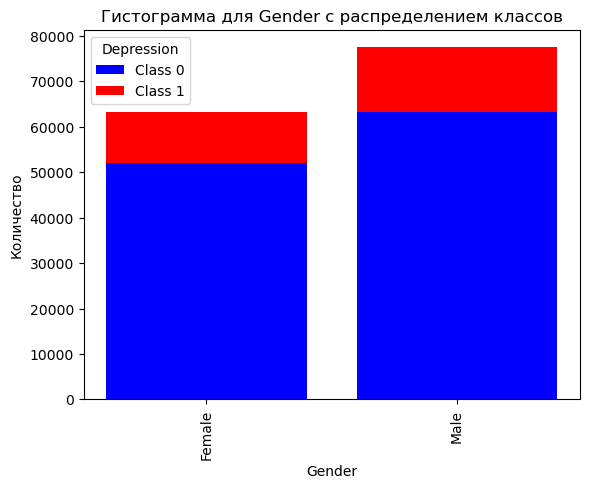

In [37]:
draw_histogram_categorical("Gender")

#### **City**

In [8]:
len(df["City"].unique().tolist())

68

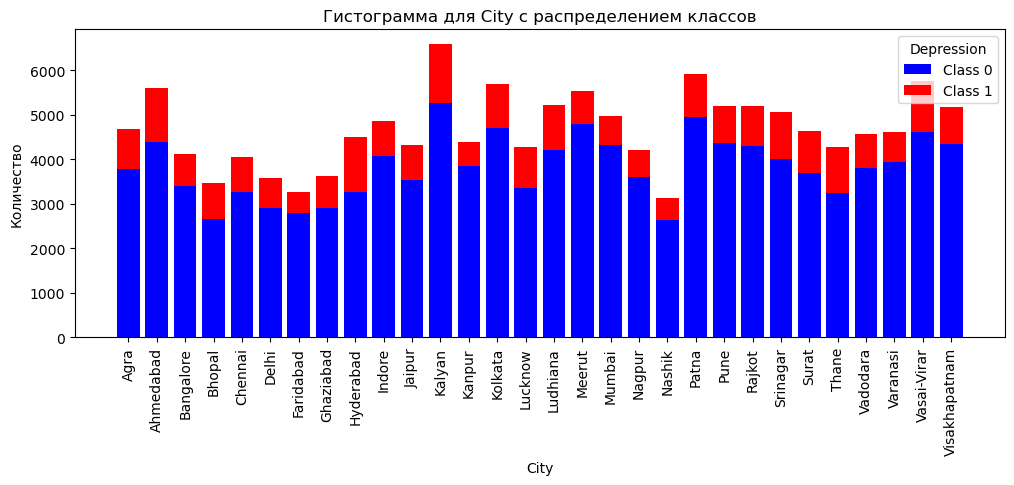

In [39]:
draw_histogram_categorical("City", figsize=(12, 4), min_count=20)

#### **Working Professional or Student**

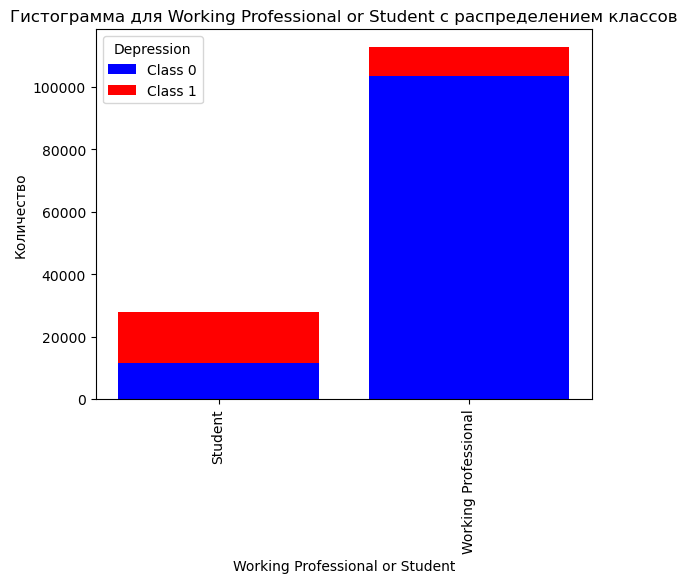

In [40]:
draw_histogram_categorical("Working Professional or Student")

#### **Family History of Mental Illness**

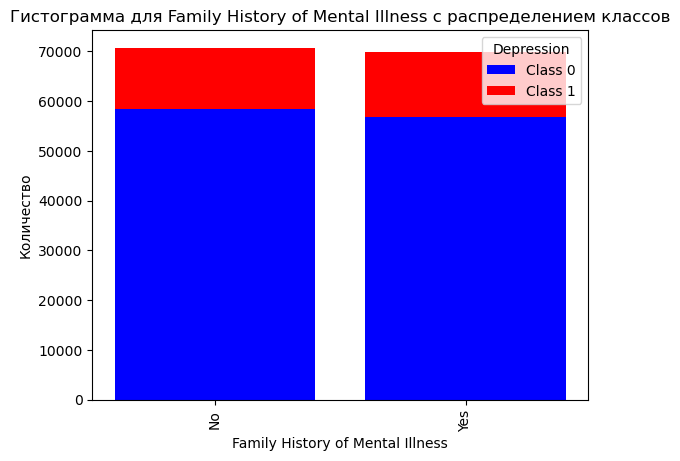

In [41]:
#draw_histogram("Family History of Mental Illness", ylim=(68_000, 72_000))
draw_histogram_categorical("Family History of Mental Illness")

#### **Have you ever had suicidal thoughts ?**

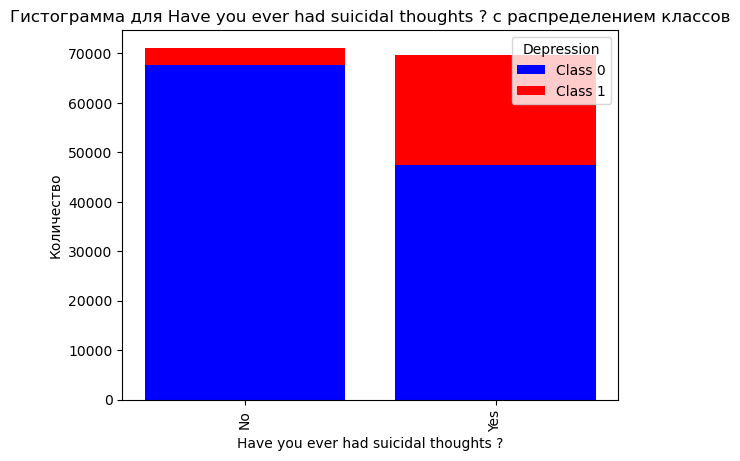

In [42]:
draw_histogram_categorical("Have you ever had suicidal thoughts ?")

#### **Degree**

In [174]:
len(df["Degree"].unique().tolist())  # to drop columns

116

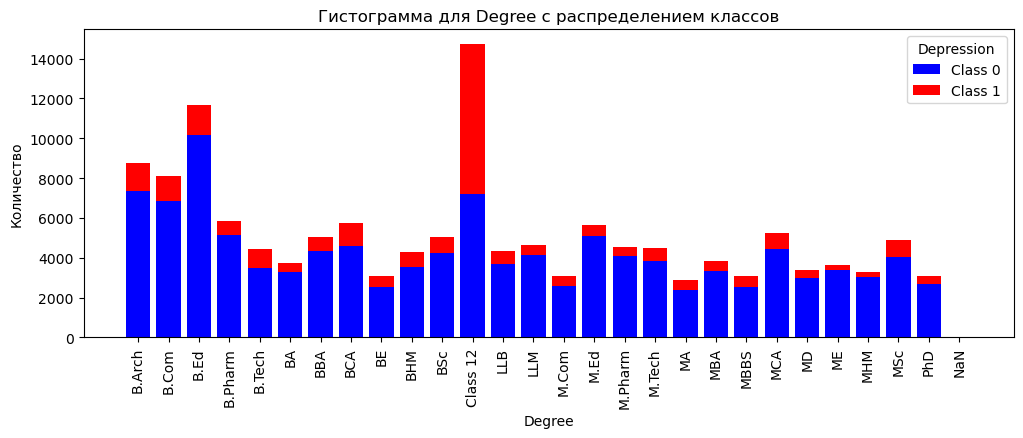

In [43]:
draw_histogram_categorical("Degree", figsize=(12, 4), min_count=10)

#### **Dietary Habits**

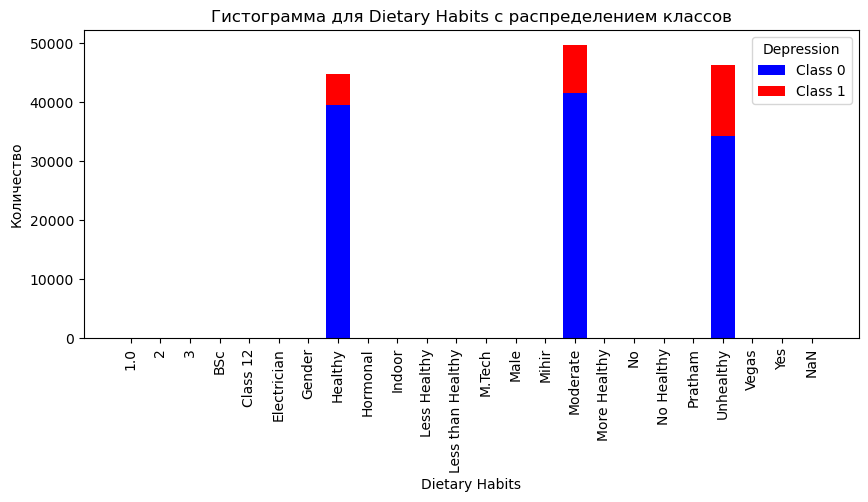

In [44]:
draw_histogram_categorical("Dietary Habits", figsize=(10, 4))

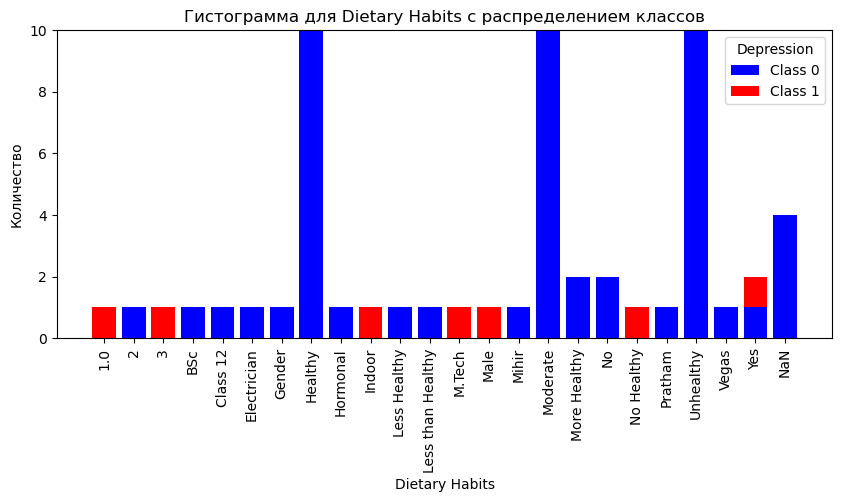

In [49]:
draw_histogram_categorical("Dietary Habits", figsize=(10, 4), ylim=(0, 10))

In [29]:
def classify_dietary_habits(value):
    if re.match(r'healthy|more healthy|more|more than', value.lower()):
        return 'Healthy'
    elif re.match(r'mealy|less healthy|less|less than|no|unhealthy', value.lower()):
        return 'Unhealthy'
    elif re.match(r'moderate', value.lower()):
        return 'Moderate'
    else:
        return 'unk'

df['Dietary Habits'] = df['Dietary Habits'].astype(str).apply(classify_dietary_habits)

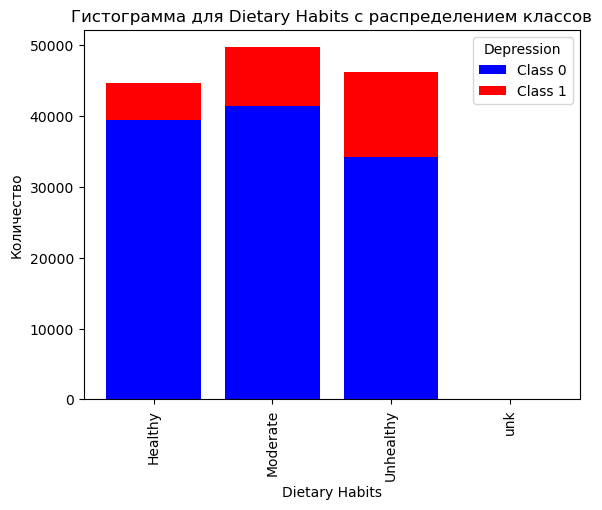

In [30]:
draw_histogram_with_classes("Dietary Habits")

#### **Sleep Duration**

In [181]:
df["Sleep Duration"].unique().tolist() # Need to clean

['More than 8 hours',
 'Less than 5 hours',
 '5-6 hours',
 '7-8 hours',
 'Sleep_Duration',
 '1-2 hours',
 '6-8 hours',
 '4-6 hours',
 '6-7 hours',
 '10-11 hours',
 '8-9 hours',
 '40-45 hours',
 '9-11 hours',
 '2-3 hours',
 '3-4 hours',
 'Moderate',
 '55-66 hours',
 '4-5 hours',
 '9-6 hours',
 '1-3 hours',
 'Indore',
 '45',
 '1-6 hours',
 '35-36 hours',
 '8 hours',
 'No',
 '10-6 hours',
 'than 5 hours',
 '49 hours',
 'Unhealthy',
 'Work_Study_Hours',
 '3-6 hours',
 '45-48 hours',
 '9-5',
 'Pune',
 '9-5 hours']

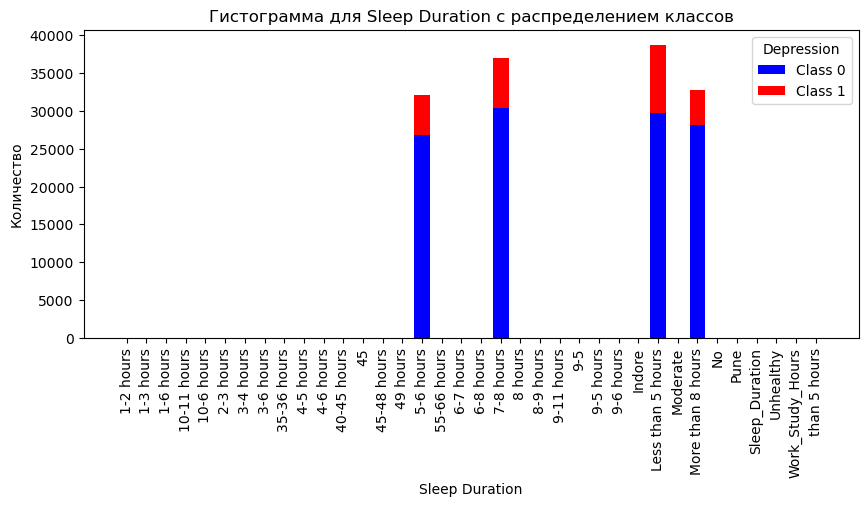

In [45]:
draw_histogram_categorical("Sleep Duration", figsize=(10, 4))

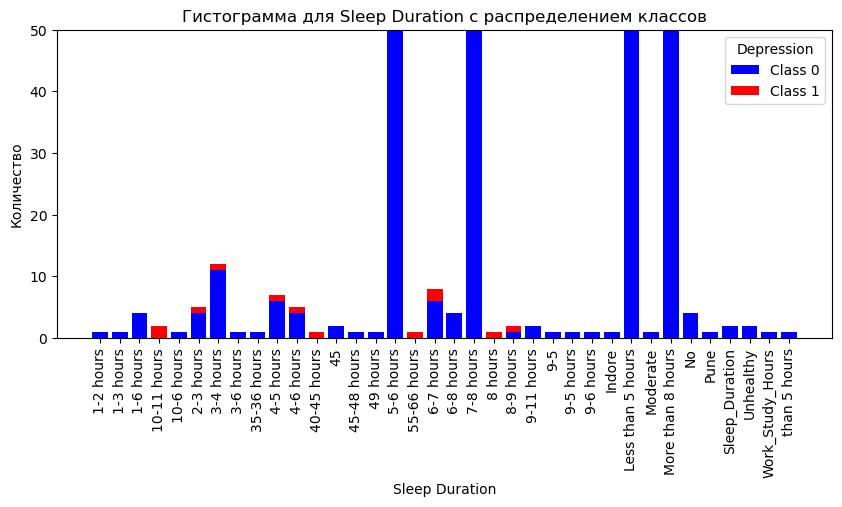

In [46]:
draw_histogram_categorical("Sleep Duration", figsize=(10, 4), ylim=(0, 50))

In [184]:
def classify_sleep_duration(value):
    if re.match(r'less than 5 hours|1|2|3|4|than 5|than 6', value.lower()):
        return '< 5'
    elif re.match(r'5|6|7|5-|6-|5-6 hours|5-7 hours|6-7 hours|5 hours|6 hours|7 hours', value.lower()):
        return '5-7'
    elif re.match(r'more than 8 hours|9-|10-|11-|40-|45-|50-|60-|8-89 hours|than 9|than 8', value.lower()):
        return '> 8'
    else:
        return 'unk'
        
df['Sleep Duration'] = df['Sleep Duration'].apply(classify_sleep_duration)

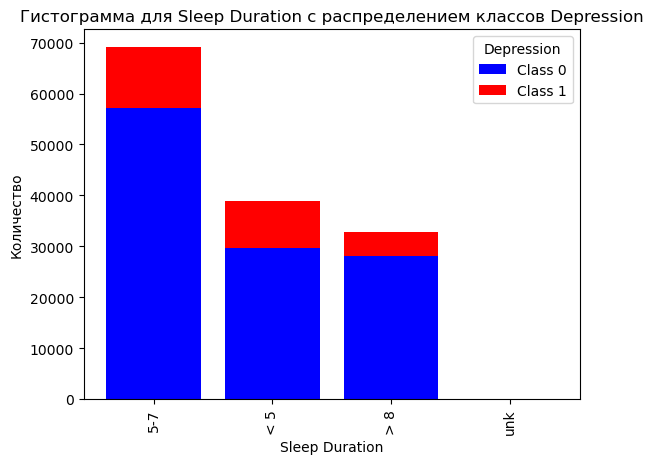

In [189]:
draw_histogram_categorical("Sleep Duration")

#### **Profession**

In [42]:
df["Profession"].unique().tolist() # NaN, Moderate, Yogesh, Nagpur, Unevil, No to Unknown 

['Judge',
 'Educational Consultant',
 'Teacher',
 nan,
 'Customer Support',
 'Chemist',
 'Content Writer',
 'Consultant',
 'HR Manager',
 'Research Analyst',
 'Digital Marketer',
 'Electrician',
 'Marketing Manager',
 'Plumber',
 'Pharmacist',
 'Lawyer',
 'Pilot',
 'Architect',
 'Chef',
 'Graphic Designer',
 'Entrepreneur',
 'Manager',
 'Mechanical Engineer',
 'Software Engineer',
 'Travel Consultant',
 'Finanancial Analyst',
 'Financial Analyst',
 'Doctor',
 'Business Analyst',
 'UX/UI Designer',
 'Sales Executive',
 'Data Scientist',
 'Accountant',
 'Researcher',
 'Civil Engineer',
 'Investment Banker',
 'Unhealthy',
 'B.Ed',
 'Student',
 'Working Professional',
 '3M',
 'ME',
 'B.Pharm',
 '24th',
 'Manvi',
 'Yogesh',
 'Samar',
 'Surat',
 'PhD',
 'M.Ed',
 'MD',
 'Name',
 'MCA',
 'Simran',
 'Analyst',
 'Profession',
 'Unemployed',
 'BBA',
 'M.Tech',
 'LLM',
 'Surgeon',
 'No',
 'Unveil',
 'City Consultant',
 'M.Pharm']

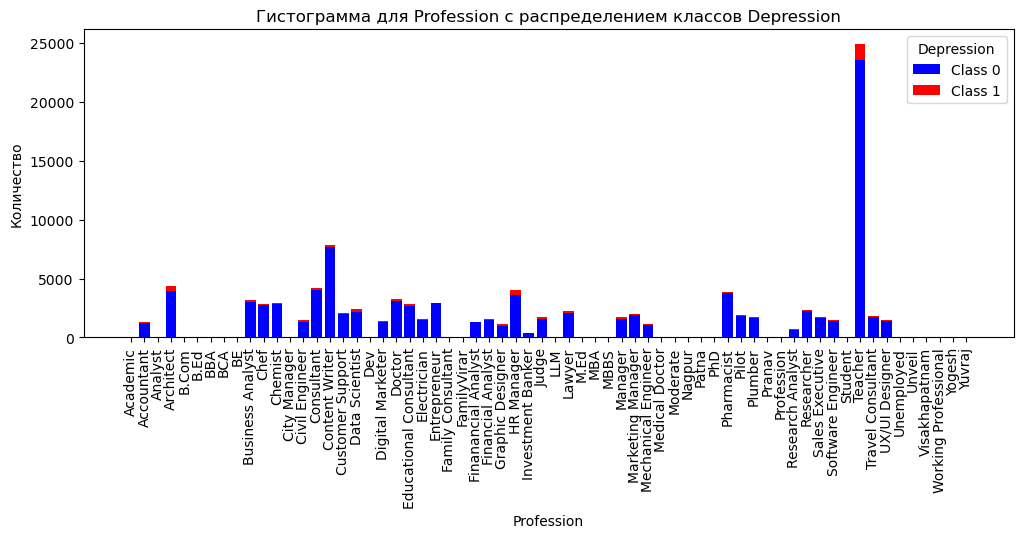

In [186]:
draw_histogram_categorical("Profession", figsize=(12, 4))

### **Числовые данные**

In [53]:
df[num_cols].describe()

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [52]:
df[num_cols].isna().sum()

id                         0
Age                        0
Academic Pressure     112803
Work Pressure          27918
CGPA                  112802
Study Satisfaction    112803
Job Satisfaction       27910
Work/Study Hours           0
Financial Stress           4
Depression                 0
dtype: int64

#### **Age**

In [22]:
len(df["Age"].unique().tolist())

43

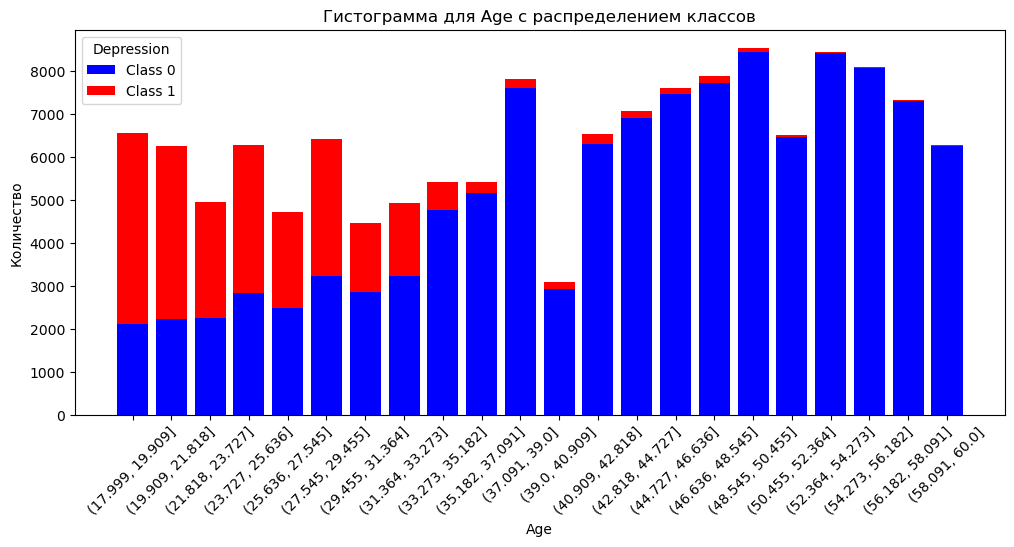

In [98]:
draw_histogram_numeric("Age", figsize=(12,5), bins=22)

#### **Academic Pressure**

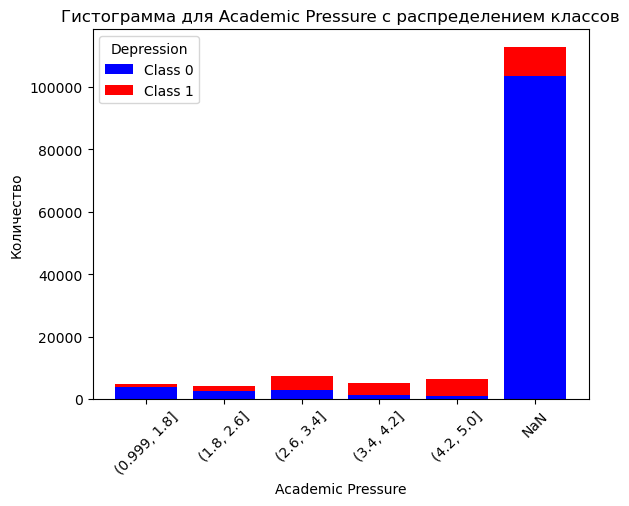

In [99]:
draw_histogram_numeric("Academic Pressure", bins=5)

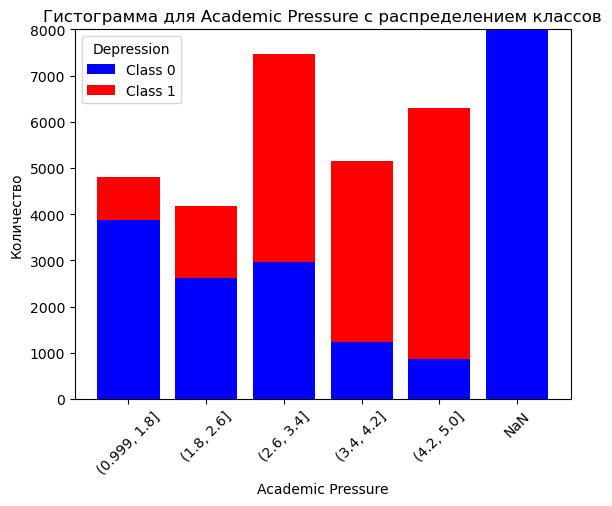

In [84]:
draw_histogram_numeric("Academic Pressure", bins=5, ylim=(0, 8000))

#### **Work Pressure**

In [160]:
df["Work Pressure"].unique().tolist()

[5.0, 4.0, nan, 1.0, 2.0, 3.0]

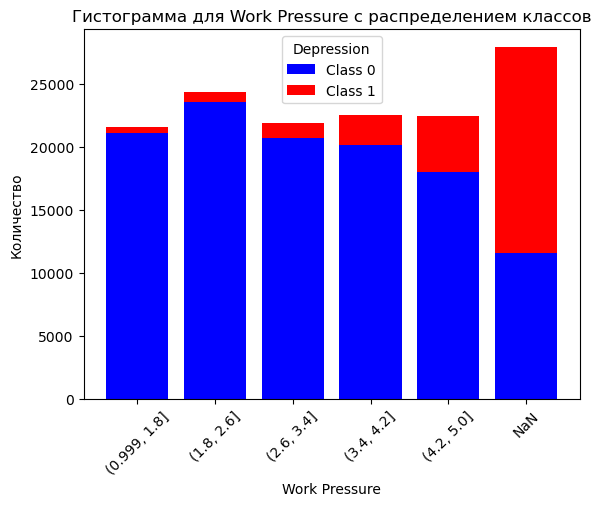

In [68]:
draw_histogram_numeric("Work Pressure", bins=5)

#### **CGPA**

In [69]:
len(df["CGPA"].unique().tolist())

332

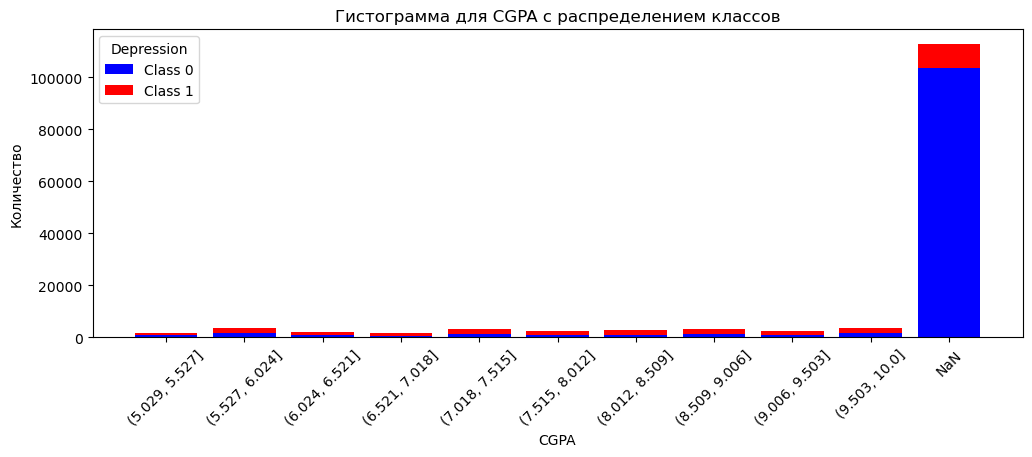

In [76]:
draw_histogram_numeric("CGPA", bins=10, figsize=(12, 4))

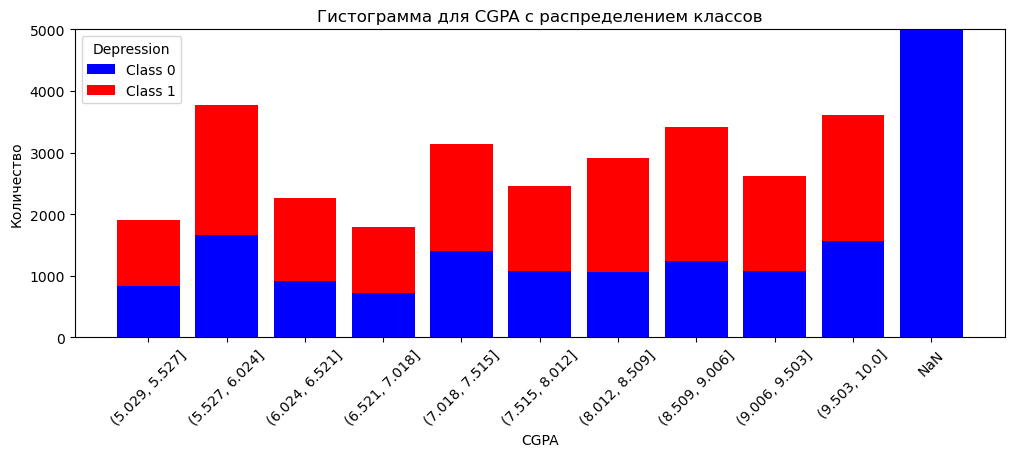

In [77]:
draw_histogram_numeric("CGPA", bins=10, figsize=(12, 4), ylim=(0, 5000))

#### **Study Satisfaction**

In [79]:
df["Study Satisfaction"].unique().tolist()

[nan, 2.0, 5.0, 3.0, 4.0, 1.0]

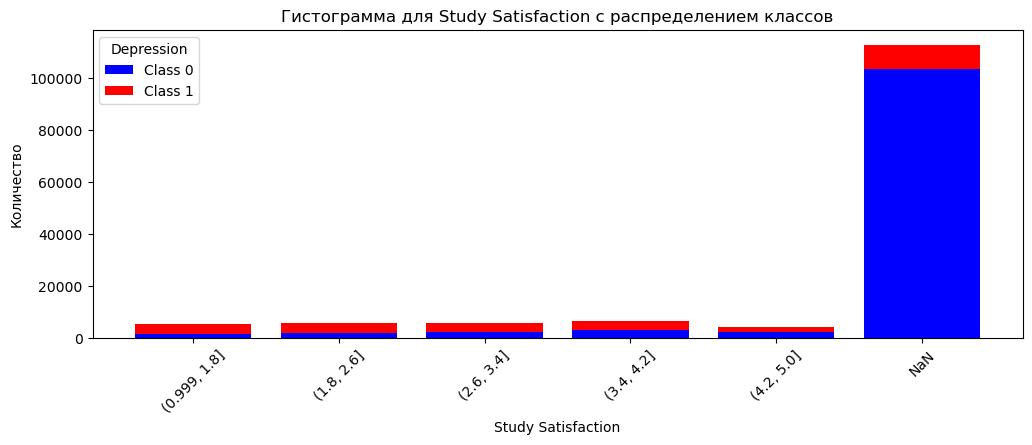

In [80]:
draw_histogram_numeric("Study Satisfaction", bins=5, figsize=(12, 4))

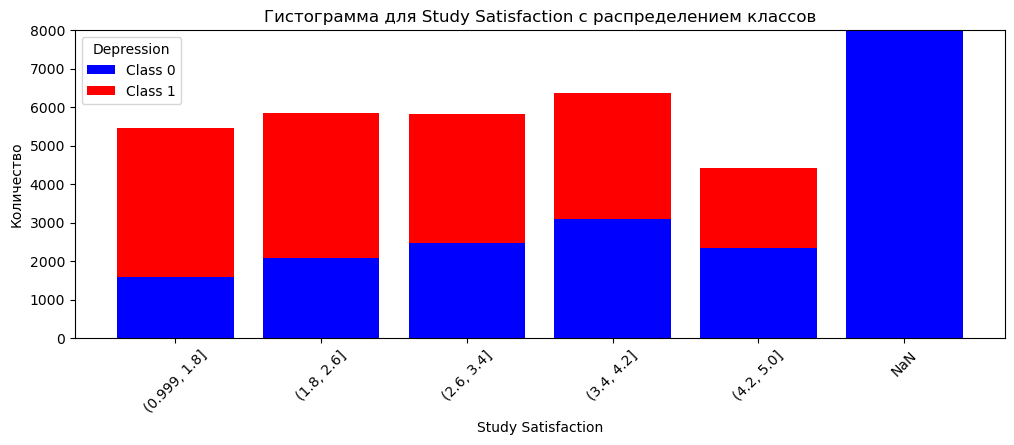

In [83]:
draw_histogram_numeric("Study Satisfaction", bins=5, figsize=(12, 4), ylim=(0, 8000))

#### **Job Satisfaction**

In [163]:
df["Job Satisfaction"].unique().tolist()

[2.0, 3.0, nan, 1.0, 5.0, 4.0]

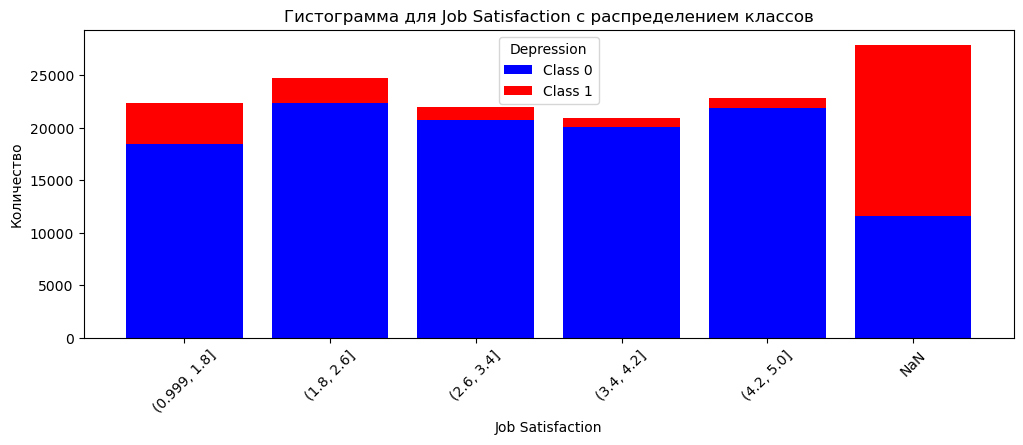

In [85]:
draw_histogram_numeric("Job Satisfaction", bins=5, figsize=(12, 4))

#### **Financial Stress**

In [164]:
df["Financial Stress"].unique().tolist()

[2.0, 3.0, 1.0, 4.0, 5.0, nan]

In [89]:
df["Financial Stress"].isna().sum()

4

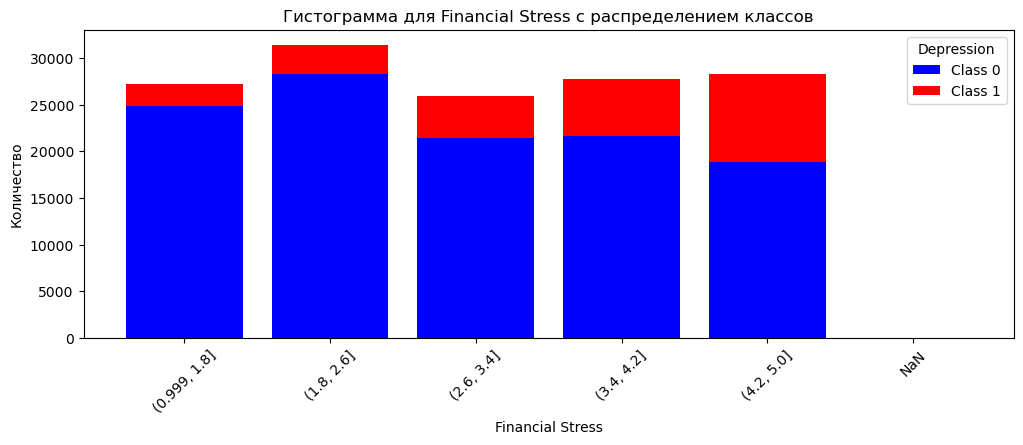

In [86]:
draw_histogram_numeric("Financial Stress", bins=5, figsize=(12, 4))

#### **Work/Study Hours**

In [165]:
df["Work/Study Hours"].unique().tolist()

[1.0, 7.0, 3.0, 10.0, 9.0, 6.0, 8.0, 2.0, 0.0, 5.0, 12.0, 4.0, 11.0]

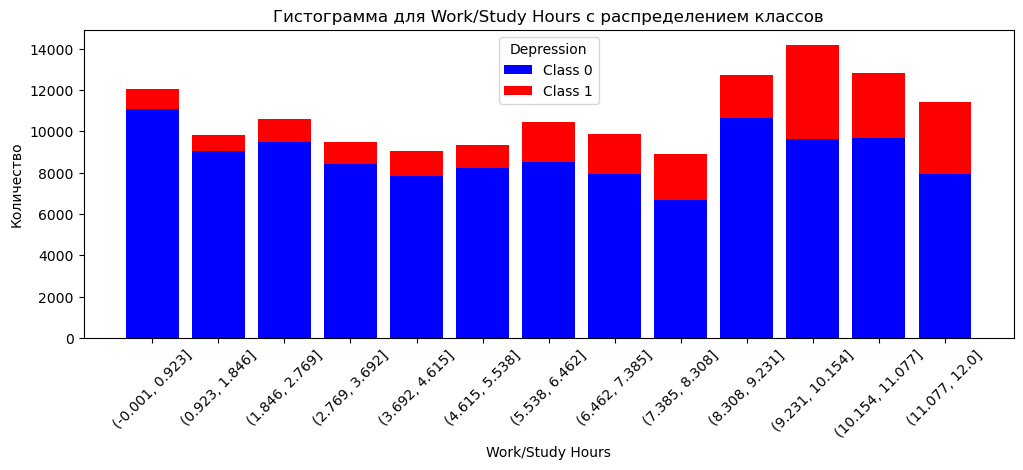

In [90]:
draw_histogram_numeric("Work/Study Hours", bins=13, figsize=(12, 4))

## Обработка данных

Функция **preproccess_dataset** выполняет предобработку датасета, а именно: 

- удаляет столбцы **id** и **Name**;
- пересобирает данные из столбцов **Sleep Duration** и **Dietary Habits**;
- заменяет категории, которые встречаются в датасете менее 10 раз, на **"unk"**;
- заменяет NaN-значения в категориальных столбцах на **"unk"**;
- заменяет NaN-значения в числовых столбцах на **медиану**;
    

In [62]:
def preproccess_dataset(df):

    def classify_dietary_habits(value):
        if re.match(r'healthy|more healthy|more|more than', value.lower()):
            return 'Healthy'
        elif re.match(r'mealy|less healthy|less|less than|no|unhealthy', value.lower()):
            return 'Unhealthy'
        elif re.match(r'moderate', value.lower()):
            return 'Moderate'
        else:
            return 'unk'
    
    def classify_sleep_duration(value):
        if re.match(r'less than 5 hours|1|2|3|4|than 5|than 6', value.lower()):
            return '< 5'
        elif re.match(r'5|6|7|5-|6-|5-6 hours|5-7 hours|6-7 hours|5 hours|6 hours|7 hours', value.lower()):
            return '5-7'
        elif re.match(r'more than 8 hours|9-|10-|11-|40-|45-|50-|60-|8-89 hours|than 9|than 8', value.lower()):
            return '> 8'
        else:
            return 'unk'

    df.drop('id', axis=1, inplace=True)
    df.drop('Name', axis=1, inplace=True)
    
    df['Sleep Duration'] = df['Sleep Duration'].astype(str).apply(classify_sleep_duration)
    df['Dietary Habits'] = df['Dietary Habits'].astype(str).apply(classify_dietary_habits)
   
    cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)
    for col in cat_cols:
        value_counts = df[col].value_counts()
        rare_categories = value_counts[value_counts < 10].index
        df[col] = df[col].apply(lambda x: 'unk' if pd.isna(x) or x in rare_categories else x)
    
    num_cols = list(df.select_dtypes(include=[int, float]).columns)
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    
    #print('Числовые столбцы:', (num_cols))
    #print('Категориальные столбцы:', (cat_cols))

    for feature in cat_cols:
        df[feature] = df[feature].astype('category')

    return df, num_cols, cat_cols

In [105]:
df, num_cols, cat_cols = preproccess_dataset(df)

Числовые столбцы: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']
Категориальные столбцы: ['Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


In [107]:
df.isna().sum()

Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [106]:
df

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Female,49.0,Ludhiana,Working Professional,Chef,3.0,5.0,7.77,3.0,2.0,> 8,Healthy,BHM,No,1.0,2.0,No,0
1,Male,26.0,Varanasi,Working Professional,Teacher,3.0,4.0,7.77,3.0,3.0,< 5,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Male,33.0,Visakhapatnam,Student,unk,5.0,3.0,8.97,2.0,3.0,5-7,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Male,22.0,Mumbai,Working Professional,Teacher,3.0,5.0,7.77,3.0,1.0,< 5,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Female,30.0,Kanpur,Working Professional,Business Analyst,3.0,1.0,7.77,3.0,1.0,5-7,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,Female,18.0,Ahmedabad,Working Professional,unk,3.0,5.0,7.77,3.0,4.0,5-7,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,Female,41.0,Hyderabad,Working Professional,Content Writer,3.0,5.0,7.77,3.0,4.0,5-7,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,Female,24.0,Kolkata,Working Professional,Marketing Manager,3.0,3.0,7.77,3.0,1.0,> 8,Moderate,B.Com,No,4.0,4.0,No,0
140698,Female,49.0,Srinagar,Working Professional,Plumber,3.0,5.0,7.77,3.0,2.0,5-7,Moderate,ME,Yes,10.0,1.0,No,0


In [111]:
df[cat_cols].nunique()

Gender                                    2
City                                     31
Working Professional or Student           2
Profession                               36
Sleep Duration                            4
Dietary Habits                            4
Degree                                   28
Have you ever had suicidal thoughts ?     2
Family History of Mental Illness          2
dtype: int64

In [110]:
df.to_csv('processed_train.csv', index=False)

# CatBoost

In [63]:
submission_df = pd.read_csv('test.csv')
submission_df, num_cols, cat_cols = preproccess_dataset(submission_df)
submission_df.head()

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Male,53.0,Visakhapatnam,Working Professional,Judge,3.0,2.0,7.80,3.0,5.0,< 5,Moderate,LLB,No,9.0,3.0,Yes
1,Female,58.0,Kolkata,Working Professional,Educational Consultant,3.0,2.0,7.80,3.0,4.0,< 5,Moderate,B.Ed,No,6.0,4.0,No
2,Male,53.0,Jaipur,Working Professional,Teacher,3.0,4.0,7.80,3.0,1.0,5-7,Moderate,B.Arch,Yes,12.0,4.0,No
3,Female,23.0,Rajkot,Student,unk,5.0,3.0,6.84,1.0,3.0,> 8,Moderate,BSc,Yes,10.0,4.0,No
4,Male,47.0,Kalyan,Working Professional,Teacher,3.0,5.0,7.80,3.0,5.0,5-7,Moderate,BCA,Yes,3.0,4.0,No


In [159]:
df = pd.read_csv('processed_train.csv')
target = 'Depression'
labels = df[target]
df.drop(target, axis=1, inplace=True)
num_cols = list(df.select_dtypes(include=[int, float]).columns)
cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)

In [52]:
X_train, X_test_val, y_train, y_test_val = train_test_split(df, labels, test_size=0.20, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.3, random_state=65)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_cols)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
print(f'Размер train-части: {len(y_train)}\nРазмер val-части:   {len(y_val)}\nРазмер test-части:  {len(y_test)}')

Размер train-части: 112560
Размер val-части:   19698
Размер test-части:  8442


In [53]:
print(f'Соотношение классов в train-наборе: {len(y_train[y_train == 1])}/{len(y_train[y_train == 0])} = {(len(y_train[y_train == 1])/len(y_train[y_train == 0])):.4f}')
print(f'Соотношение классов в val-наборе:   {len(y_val[y_val == 1])}/{len(y_val[y_val == 0])} = {(len(y_val[y_val == 1])/len(y_val[y_val == 0])):.4f}')
print(f'Соотношение классов в test-наборе:  {len(y_test[y_test == 1])}/{len(y_test[y_test == 0])} = {(len(y_test[y_test == 1])/len(y_test[y_test == 0])):.4f}')


Соотношение классов в train-наборе: 20377/92183 = 0.2210
Соотношение классов в val-наборе:   3581/16117 = 0.2222
Соотношение классов в test-наборе:  1609/6833 = 0.2355


## Классический CatBoost

In [58]:
model = CatBoostClassifier(random_seed=56,
                              iterations=1000,
                              eval_metric='Accuracy',
                              custom_metric=['AUC', 'F1', 'Precision', 'Recall'],
                              learning_rate=0.035,
                              l2_leaf_reg=4,
                              bagging_temperature=1,
                              random_strength=4,
                              use_best_model=True,
                              early_stopping_rounds=250,
                              verbose=100
)
model.fit(X=train_pool, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9125800	test: 0.9108031	best: 0.9108031 (0)	total: 120ms	remaining: 1m 59s
100:	learn: 0.9365849	test: 0.9344604	best: 0.9344604 (100)	total: 9.18s	remaining: 1m 21s
200:	learn: 0.9390458	test: 0.9354249	best: 0.9356787 (139)	total: 18.1s	remaining: 1m 11s
300:	learn: 0.9398099	test: 0.9366433	best: 0.9366433 (300)	total: 26.2s	remaining: 1m
400:	learn: 0.9407960	test: 0.9367956	best: 0.9369479 (355)	total: 35.1s	remaining: 52.5s
500:	learn: 0.9414534	test: 0.9370494	best: 0.9371002 (405)	total: 44.1s	remaining: 43.9s
600:	learn: 0.9420753	test: 0.9376079	best: 0.9376586 (590)	total: 53.6s	remaining: 35.6s
700:	learn: 0.9426528	test: 0.9378617	best: 0.9379632 (691)	total: 1m 3s	remaining: 27s
800:	learn: 0.9432303	test: 0.9378109	best: 0.9381663 (721)	total: 1m 13s	remaining: 18.2s
900:	learn: 0.9439144	test: 0.9379125	best: 0.9381663 (721)	total: 1m 23s	remaining: 9.14s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.9381663113
bestIteration = 721

Shr

Размер проверочного датасета: 8442
Accuracy: 0.936982
ROC-AUC: 0.975403
F1 Score: 0.829596
Precision: 0.855915
Recall: 0.804848


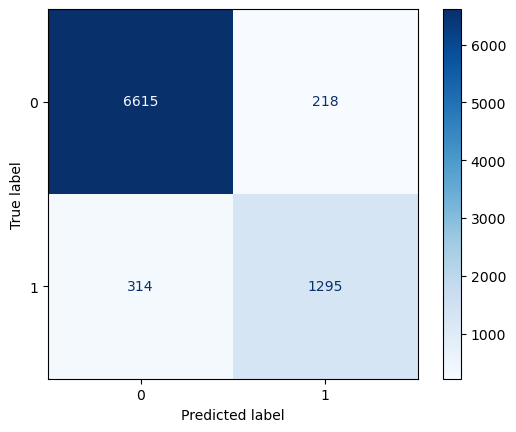

In [59]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
show_metrics(model, y_pred, y_pred_proba)

In [60]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Accuracy',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 4,
 'random_strength': 4,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': [

In [64]:
predictions = model.predict(submission_df)
submit_predictions(predictions, filename='catboost_baseline_1')

Файл catboost_baseline_1.csv сохранен.


**Public score:  0.94136**

**Private score: 0.94027**

## CatBoost + ансамблирование

In [139]:
df = pd.read_csv('processed_train.csv')

In [140]:
train, val_test = train_test_split(df, test_size=0.20, random_state=56)
val, test = train_test_split(val_test, test_size=0.3, random_state=65)
print(f'Размер train-части: {len(train)}\nРазмер val-части:   {len(val)}\nРазмер test-части:  {len(test)}')

Размер train-части: 112560
Размер val-части:   19698
Размер test-части:  8442


In [141]:
train_val = pd.concat([train, val])
y_train_val = train_val[target]
X_train_val = train_val.drop(target, axis=1)
train_val_pool = Pool(data=X_train_val, label=y_train_val, cat_features=cat_cols) 
print(f'Размер train+val-части: {len(y_train_val)}')

Размер train+val-части: 132258


### Ансамбль с голосованием по большинству

#### N_folds = 5

In [69]:
params = {
    "iterations": 800,
    "learning_rate": 0.045,
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    "bagging_temperature": 1,
    "random_strength": 4,
    "l2_leaf_reg": 4,
    "early_stopping_rounds": 150,
    "verbose": 100
}

models = cv(
    params=params,
    pool=train_val_pool,
    fold_count=5,                
    partition_random_seed=156,    
    stratified=True,             
    verbose=False,
    seed=56,
    plot=True,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9406094057
bestIteration = 348

Training on fold [1/5]

bestTest = 0.9389082111
bestIteration = 594

Training on fold [2/5]

bestTest = 0.9372448208
bestIteration = 357

Training on fold [3/5]

bestTest = 0.9424218366
bestIteration = 487

Training on fold [4/5]

bestTest = 0.9398132396
bestIteration = 660



In [70]:
for i in range(len(models[1])):
    models[1][i] = catboost.to_classifier(models[1][i])

Размер проверочного датасета: 8442
Accuracy: 0.937811
F1 Score: 0.832322
Precision: 0.856110
Recall: 0.809820


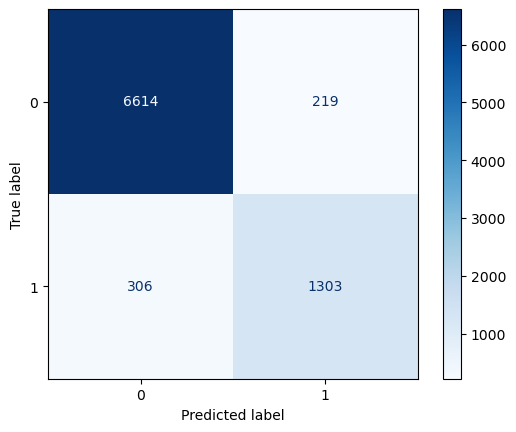

In [71]:
y_test = test[target]
X_test = test.drop(target, axis=1)
cv_ensemble_preds = majority_vote_with_metrics(models[1], X_test, y_test)

In [72]:
predictions = np.array([model.predict(submission_df) for model in models[1]])
y_pred = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
submit_predictions(y_pred, filename='catboost_cv5_majorityVote')

Файл catboost_cv5_majorityVote.csv сохранен.


**Public score:  0.94173**

**Private score: 0.94031**

#### N_folds = 10

In [50]:
params = {
    "iterations": 800,
    "learning_rate": 0.045,
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    "bagging_temperature": 1,
    "random_strength": 4,
    "l2_leaf_reg": 4,
    "early_stopping_rounds": 150,
    "verbose": 100
}

models = cv(
    params=params,
    pool=train_val_pool,
    fold_count=10,                
    partition_random_seed=156,    
    stratified=True,             
    verbose=False,
    seed=56,
    plot=True,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.9420837744
bestIteration = 342

Training on fold [1/10]

bestTest = 0.9384545592
bestIteration = 264

Training on fold [2/10]

bestTest = 0.9380009073
bestIteration = 437

Training on fold [3/10]

bestTest = 0.9390594284
bestIteration = 98

Training on fold [4/10]

bestTest = 0.9376228641
bestIteration = 568

Training on fold [5/10]

bestTest = 0.9377740814
bestIteration = 488

Training on fold [6/10]

bestTest = 0.9431422955
bestIteration = 520

Training on fold [7/10]

bestTest = 0.9429154695
bestIteration = 395

Training on fold [8/10]

bestTest = 0.9413988658
bestIteration = 464

Training on fold [9/10]

bestTest = 0.9393572779
bestIteration = 558



In [ ]:
for i in range(len(models[1])):
    models[1][i] = catboost.to_classifier(models[1][i])

Размер проверочного датасета: 8442
Accuracy: 0.936508
F1 Score: 0.827874
Precision: 0.856478
Recall: 0.801119


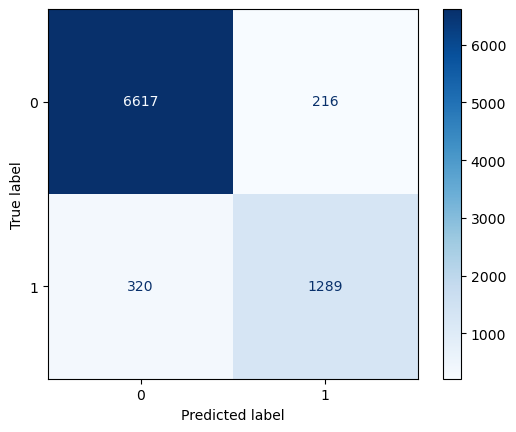

In [48]:
y_test = test[target]
X_test = test.drop(target, axis=1)
cv_ensemble_preds = majority_vote_with_metrics(models, X_test, y_test)

In [50]:
predictions = np.array([model.predict(submission_df) for model in models])
y_pred = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
submit_predictions(y_pred, filename='catboost_cv10_majorityVote')

Файл catboost_cv10_majorityVote.csv сохранен.


**Public score:  0.94195**

**Private score: 0.94023**

#### N_folds = 20

In [24]:
params = {
    "iterations": 650,
    "learning_rate": 0.0465,
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    "bagging_temperature": 1,
    "random_strength": 4,
    "l2_leaf_reg": 4,
    "early_stopping_rounds": 150,
    "verbose": 100
}

models = cv(
    params=params,
    pool=train_val_pool,
    fold_count=20,                
    partition_random_seed=156,    
    stratified=True,             
    verbose=False,
    seed=56,
    plot=True,
    return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/20]

bestTest = 0.9419325571
bestIteration = 517

Training on fold [1/20]

bestTest = 0.9419325571
bestIteration = 282

Training on fold [2/20]

bestTest = 0.9420837744
bestIteration = 176

Training on fold [3/20]

bestTest = 0.9380009073
bestIteration = 284

Training on fold [4/20]

bestTest = 0.9386057765
bestIteration = 600

Training on fold [5/20]

bestTest = 0.9366399516
bestIteration = 510

Training on fold [6/20]

bestTest = 0.9399667322
bestIteration = 267

Training on fold [7/20]

bestTest = 0.9407228187
bestIteration = 498

Training on fold [8/20]

bestTest = 0.939361863
bestIteration = 471

Training on fold [9/20]

bestTest = 0.9345229094
bestIteration = 315

Training on fold [10/20]

bestTest = 0.9398155149
bestIteration = 575

Training on fold [11/20]

bestTest = 0.9361862997
bestIteration = 382

Training on fold [12/20]

bestTest = 0.9437471647
bestIteration = 295

Training on fold [13/20]

bestTest = 0.9414789052
bestIteration = 512

Training on fold 

In [29]:
for i in range(len(models[1])):
    models[1][i] = catboost.to_classifier(models[1][i])

Размер проверочного датасета: 8442
Accuracy: 0.937100
F1 Score: 0.829753
Precision: 0.856954
Recall: 0.804226


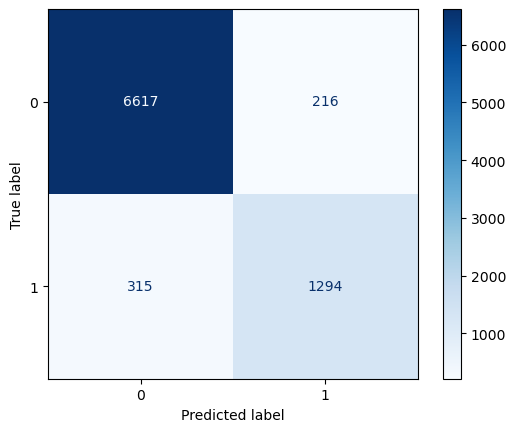

In [30]:
y_test = test[target]
X_test = test.drop(target, axis=1)
cv20_ensemble_preds = majority_vote_with_metrics(models[1], X_test, y_test)

In [44]:
predictions = np.array([model.predict(submission_df) for model in models[1]])
y_pred = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
submit_predictions(y_pred, filename='catboost_cv20_majorityVote')

Файл catboost_cv20_majorityVote.csv сохранен.


**Public score:  0.94168**

**Private score: 0.94007**

### Стекинг (CatBoostCV + NN)

In [198]:
def train_nn_model(nn_model, optimizer, criterion,
                  X_train_tensor, y_train_tensor,
                  X_val_tensor, y_val_tensor,
                  n_epochs, batch_size,
                  scheduler_step_size, scheduler_gamma):

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    best_acc = 0
    best_state = nn_model.state_dict()
    
    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    for epoch in range(n_epochs):
        nn_model.train()
        
        
        permutation = torch.randperm(X_train_tensor.size(0))
        epoch_loss = 0
        epoch_accuracy = 0
        total_batches = 0
        
        for i in range(0, X_train_tensor.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]

            optimizer.zero_grad()
            outputs = nn_model(batch_X)
    
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            predicted = (outputs >= 0.5).float()
            accuracy = accuracy_score(batch_y.numpy(), predicted.numpy())
            epoch_accuracy += accuracy
            
            total_batches += 1
        
        avg_loss = epoch_loss / total_batches
        avg_accuracy = epoch_accuracy / total_batches
        losses['train'].append(avg_loss)
        accuracies['train'].append(avg_accuracy)
        
        nn_model.eval()
        with torch.no_grad():
            val_outputs = nn_model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_predicted = (val_outputs >= 0.5).float()
            val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predicted.numpy())
        losses['val'].append(val_loss)
        accuracies['val'].append(val_accuracy)
        total_batches += 1
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_state = nn_model.state_dict()
       
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_loss:.4f}, Train Acc: {avg_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, lr: {optimizer.param_groups[0]['lr']:.6f}")
        scheduler.step()
    
    print(f'\nBest Accuracy: {best_acc}')
    nn_model.load_state_dict(best_state)
    return losses, accuracies

In [199]:
class StackingNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(StackingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(p=0.1)
        self.activation = nn.GELU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        return self.sigmoid(x)

In [124]:
def plot_training(losses={}, accuracies={}):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses['train'], label='Train', c='red')
    plt.plot(losses['val'], label='Val', c='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies['train'], label='Train', c='red')
    plt.plot(accuracies['val'], label='Val', c='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
        

In [115]:
def stacking_predict(X, catboost_cv_models, nn_model):
    catboost_cv_features = np.zeros((X.shape[0], len(catboost_cv_models)))
    for i, model in enumerate(catboost_cv_models):
        catboost_cv_features[:, i] = model.predict_proba(X)[:, 1]

    catboost_cv_features_tensor = torch.tensor(catboost_cv_features, dtype=torch.float32)
    nn_model.eval()
    with torch.no_grad():
        pred_proba = nn_model(catboost_cv_features_tensor).numpy()

    predictions = [1 if pred > 0.5 else 0 for pred in pred_proba]
    return predictions, pred_proba

#### N_folds = 5

In [74]:
import os
catboost_info_path = "catboost_info_cv5"
fold_paths = [os.path.join(catboost_info_path, folder) 
              for folder in os.listdir(catboost_info_path) 
              if folder.startswith("fold-")]
trained_models = []
for fold_path in fold_paths:
    model_path = os.path.join(fold_path, "model") 
    if os.path.exists(model_path):
        model = CatBoostClassifier()
        model.load_model(model_path)
        trained_models.append(model)
print(f"Загружено моделей: {len(trained_models)}")

Загружено моделей: 5


In [76]:
catboost_cv_features = np.zeros((df.shape[0], len(trained_models)))
for i, model in enumerate(trained_models):
    catboost_cv_features[:, i] = model.predict_proba(df)[:, 1]

In [80]:
X_train, X_test_val, y_train, y_test_val = train_test_split(catboost_cv_features, labels, test_size=0.20, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.3, random_state=65)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print(f'Размер train: {len(y_train)}, размер val: {len(y_val)}, размер test: {len(y_test)}')

Размер train: 112560, размер val: 19698, размер test: 8442


In [95]:
nn_model = StackingNN(input_dim=X_train.shape[1], hidden_dim=64) 
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 512 #37520 #56280 #16384
scheduler_step_size = 25
scheduler_gamma = 0.75
losses, accuracies = train_nn_model(nn_model, optimizer, criterion,
                                    X_train_tensor, y_train_tensor,
                                    X_val_tensor, y_val_tensor,
                                    n_epochs=n_epochs, batch_size=batch_size,
                                    scheduler_step_size=scheduler_step_size, 
                                    scheduler_gamma=scheduler_gamma)


Epoch 1/100, Train Loss: 0.5888, Train Acc: 0.9063, Val Acc: 0.9408, lr: 0.001000
Epoch 2/100, Train Loss: 0.5713, Train Acc: 0.9420, Val Acc: 0.9413, lr: 0.001000
Epoch 3/100, Train Loss: 0.5710, Train Acc: 0.9421, Val Acc: 0.9402, lr: 0.001000
Epoch 4/100, Train Loss: 0.5708, Train Acc: 0.9421, Val Acc: 0.9406, lr: 0.001000
Epoch 5/100, Train Loss: 0.5706, Train Acc: 0.9424, Val Acc: 0.9411, lr: 0.001000
Epoch 6/100, Train Loss: 0.5705, Train Acc: 0.9424, Val Acc: 0.9402, lr: 0.001000
Epoch 7/100, Train Loss: 0.5703, Train Acc: 0.9426, Val Acc: 0.9395, lr: 0.001000
Epoch 8/100, Train Loss: 0.5702, Train Acc: 0.9427, Val Acc: 0.9396, lr: 0.001000
Epoch 9/100, Train Loss: 0.5701, Train Acc: 0.9427, Val Acc: 0.9408, lr: 0.001000
Epoch 10/100, Train Loss: 0.5700, Train Acc: 0.9429, Val Acc: 0.9409, lr: 0.001000
Epoch 11/100, Train Loss: 0.5699, Train Acc: 0.9428, Val Acc: 0.9406, lr: 0.001000
Epoch 12/100, Train Loss: 0.5697, Train Acc: 0.9429, Val Acc: 0.9407, lr: 0.001000
Epoch 13/100,

In [131]:
nn_model

StackingNN(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
)

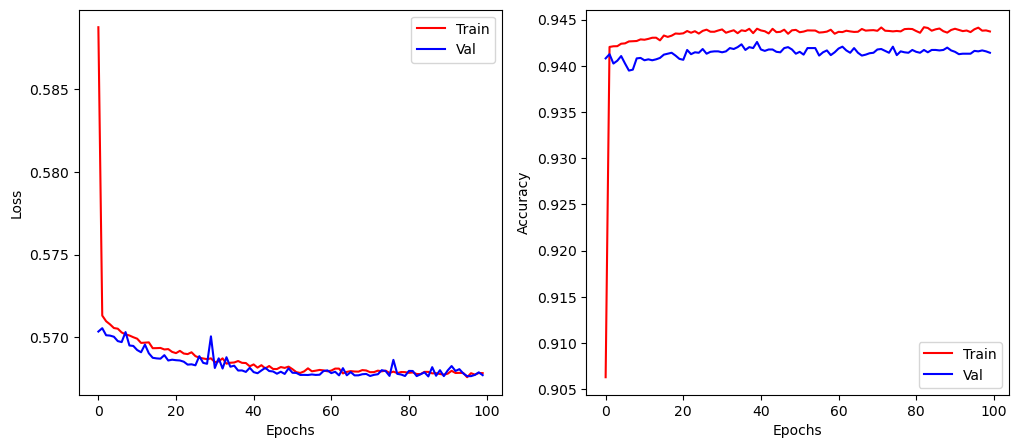

In [125]:
plot_training(losses, accuracies)

Размер проверочного датасета: 8442
Accuracy: 0.938048
ROC-AUC: 0.975124
F1 Score: 0.836204
Precision: 0.842803
Recall: 0.829708


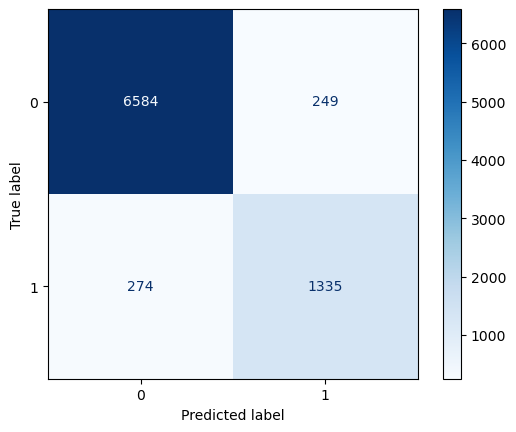

In [187]:
nn_model.eval()
with torch.no_grad():
    pred_proba = nn_model(X_test_tensor).numpy()
predictions = np.array([1 if pred > 0.5 else 0 for pred in pred_proba])

show_metrics(y_test, predictions, pred_proba)

In [104]:
submission_preds, _ = stacking_predict(submission_df, trained_models, nn_model)

In [105]:
submit_predictions(submission_preds, filename='catboost_cv5_stackingNN')

Файл catboost_cv5_stackingNN.csv сохранен.


**Public score:  0.94227**

**Private score: 0.94051**

In [129]:
torch.save(nn_model.state_dict(), 'cb_stacking/nn_model_cv5.pth')

#### N_folds = 10

In [116]:
import os
catboost_info_path = "catboost_info_cv10"
fold_paths = [os.path.join(catboost_info_path, folder) 
              for folder in os.listdir(catboost_info_path) 
              if folder.startswith("fold-")]
trained_models = []
for fold_path in fold_paths:
    model_path = os.path.join(fold_path, "model") 
    if os.path.exists(model_path):
        model = CatBoostClassifier()
        model.load_model(model_path)
        trained_models.append(model)
print(f"Загружено моделей: {len(trained_models)}")

Загружено моделей: 10


In [126]:
catboost_cv_features = np.zeros((df.shape[0], len(trained_models)))
for i, model in enumerate(trained_models):
    catboost_cv_features[:, i] = model.predict_proba(df)[:, 1]

In [127]:
X_train, X_test_val, y_train, y_test_val = train_test_split(catboost_cv_features, labels, test_size=0.20, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.3, random_state=65)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print(f'Размер train: {len(y_train)}, размер val: {len(y_val)}, размер test: {len(y_test)}')

Размер train: 112560, размер val: 19698, размер test: 8442


In [132]:
nn_model = StackingNN(input_dim=X_train.shape[1], hidden_dim=64) 
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 512 #37520 #56280 #16384
scheduler_step_size = 20
scheduler_gamma = 0.75
losses, accuracies = train_nn_model(nn_model, optimizer, criterion,
                                    X_train_tensor, y_train_tensor,
                                    X_val_tensor, y_val_tensor,
                                    n_epochs=n_epochs, batch_size=batch_size,
                                    scheduler_step_size=25, scheduler_gamma=0.75)


Epoch 1/100, Train Loss: 0.5856, Train Acc: 0.9264, Val Acc: 0.9411, lr: 0.001000
Epoch 2/100, Train Loss: 0.5709, Train Acc: 0.9423, Val Acc: 0.9415, lr: 0.001000
Epoch 3/100, Train Loss: 0.5706, Train Acc: 0.9426, Val Acc: 0.9407, lr: 0.001000
Epoch 4/100, Train Loss: 0.5703, Train Acc: 0.9429, Val Acc: 0.9412, lr: 0.001000
Epoch 5/100, Train Loss: 0.5703, Train Acc: 0.9432, Val Acc: 0.9422, lr: 0.001000
Epoch 6/100, Train Loss: 0.5699, Train Acc: 0.9431, Val Acc: 0.9406, lr: 0.001000
Epoch 7/100, Train Loss: 0.5696, Train Acc: 0.9436, Val Acc: 0.9421, lr: 0.001000
Epoch 8/100, Train Loss: 0.5695, Train Acc: 0.9438, Val Acc: 0.9418, lr: 0.001000
Epoch 9/100, Train Loss: 0.5692, Train Acc: 0.9440, Val Acc: 0.9425, lr: 0.001000
Epoch 10/100, Train Loss: 0.5691, Train Acc: 0.9443, Val Acc: 0.9432, lr: 0.001000
Epoch 11/100, Train Loss: 0.5690, Train Acc: 0.9446, Val Acc: 0.9426, lr: 0.001000
Epoch 12/100, Train Loss: 0.5689, Train Acc: 0.9445, Val Acc: 0.9421, lr: 0.001000
Epoch 13/100,

In [133]:
nn_model

StackingNN(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
)

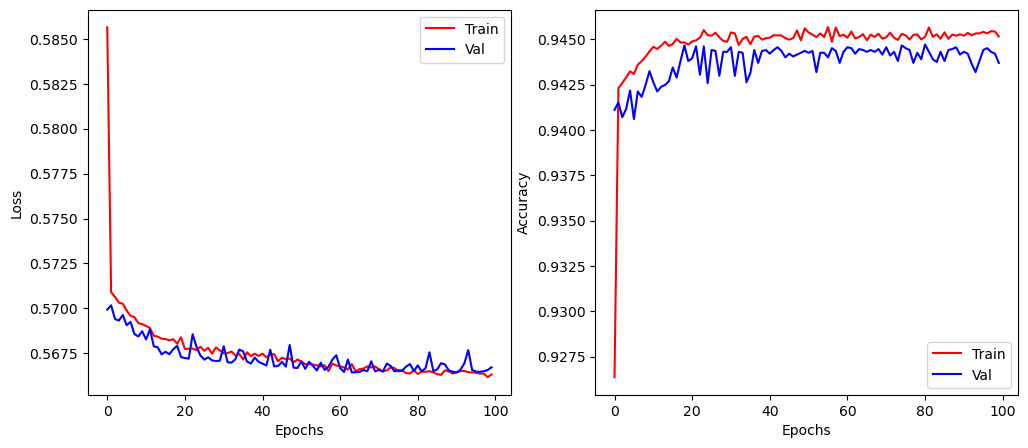

In [134]:
plot_training(losses, accuracies)

Размер проверочного датасета: 8442
Accuracy: 0.936271
ROC-AUC: 0.956872
F1 Score: 0.825325
Precision: 0.864038
Recall: 0.789932


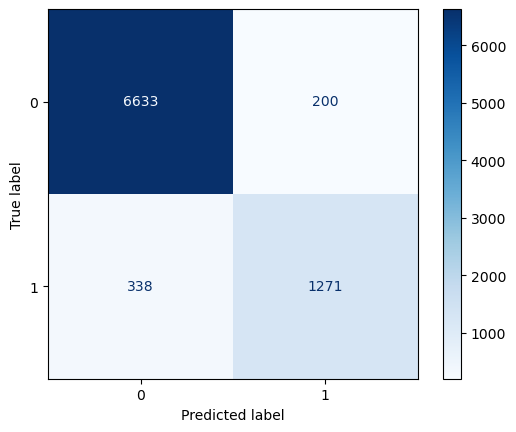

In [135]:
nn_model.eval()
with torch.no_grad():
    pred_proba = nn_model(X_test_tensor).numpy()
predictions = np.array([1 if pred > 0.5 else 0 for pred in pred_proba])

show_metrics(y_test, predictions, pred_proba)

In [136]:
submission_preds, _ = stacking_predict(submission_df, trained_models, nn_model)

In [137]:
submit_predictions(submission_preds, filename='catboost_cv10_stackingNN')

Файл catboost_cv10_stackingNN.csv сохранен.


**Public score:  0.94200**

**Private score: 0.93908**

In [138]:
torch.save(nn_model.state_dict(), 'cb_stacking/nn_model_cv10.pth')

### Балансировка классов

Так как данные в датасете сильно несбалансированы, можно попробовать сделать балансировку данных простым способом. 

- Создадим датасет с равномерным распределением классов (т.е. кол-во объектов обоих классов будет одинаковым). В тренировочном+валидационном датасете (train_val) объектов с классом 0 - 23958, а объектов с классом 1 - 108300. 108300 / 23958 ~ 4.5, следовательно, можно создать 4 полных датасета, в котором будут 23958 объектов первого класса и столько же нулевого, и 1 несбалансированный датасет, куда войдут оставшиеся данные. Объекты нулевого класса будем дублировать из train_val датасета (т.е. будет пять датасетов с одинаковыми объектами нулевого класса).

- Затем обучим на каждом датасете модель CatBoost/CatBoostCV и применим ансамблирование с нейронной сетью.

В результате модели показывают неплохие метрики на private-датасете.

In [202]:
class_0 = train_val[train_val[target] == 0]
class_1 = train_val[train_val[target] == 1]
print(f'Количество объектов класса 0: {len(class_0)}')
print(f'Количество объектов класса 1: {len(class_1)}')

Количество объектов класса 0: 108300
Количество объектов класса 1: 23958


In [203]:
datasets = []
subset_1_len = len(class_1)
subset_1_fixed = class_1.sample(n=subset_1_len, random_state=56)
flag = True
while flag:
    if len(class_0) > subset_1_len:
        subset_0_len = subset_1_len
    else:
        subset_0_len = len(class_0)
        flag = False
    subset_0 = class_0.sample(n=subset_0_len, random_state=56)
    
    # Удаляем выбранные записи класса 0 из общего набора
    class_0 = class_0.drop(subset_0.index)
    
    # Создаем сбалансированный датасет и добавляем его в список
    balanced_dataset = pd.concat([subset_0, subset_1_fixed]).sample(frac=1, random_state=56).reset_index(drop=True)
    datasets.append(balanced_dataset)

balanced_df_labels = []
for i, data in enumerate(datasets):
    balanced_df_labels.append(datasets[i][target])
    datasets[i].drop(target, axis=1, inplace=True)
    print(data.shape)

(47916, 17)
(47916, 17)
(47916, 17)
(47916, 17)
(36426, 17)


In [205]:
class_0_0 = balanced_df_labels[0][balanced_df_labels[0] == 0]
class_1_0 = balanced_df_labels[0][balanced_df_labels[0] == 1]
print(len(class_0_0), len(class_1_0))

23958 23958


#### Классический CatBoost + Нейронная сеть

In [152]:
models = []
y_test = test[target]
X_test = test.drop(target, axis=1)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols) 
print(f'Размер test-части: {len(y_test)}\n')

accuracies = 0
for i in range(len(datasets)):
    print(f'Training {i+1} model:')
    train_val_pool = Pool(data=datasets[i], label=balanced_df_labels[i], cat_features=cat_cols)
    model = CatBoostClassifier(random_seed=56+i,
                                  iterations=1000,
                                  eval_metric='Accuracy',
                                 # custom_metric=['AUC', 'F1', 'Precision', 'Recall'],
                                  learning_rate=0.035,
                                  l2_leaf_reg=4,
                                  bagging_temperature=1,
                                  random_strength=4,
                                  use_best_model=True,
                                  early_stopping_rounds=250,
                                  verbose=100
    )
    model.fit(X=train_val_pool, eval_set=test_pool, plot=False)

    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f'Model_{i+1}\'s Accuracy: {acc:.6f}')
    accuracies += acc
    models.append(model)

print(f'\nAverage Accuracy: {accuracies/len(datasets):.6f}')

Размер test-части: 8442

Training 1 model:
0:	learn: 0.8881584	test: 0.8943378	best: 0.8943378 (0)	total: 62.7ms	remaining: 1m 2s
100:	learn: 0.9174389	test: 0.9085525	best: 0.9086709 (97)	total: 6.03s	remaining: 53.7s
200:	learn: 0.9212163	test: 0.9126984	best: 0.9129353 (153)	total: 11.7s	remaining: 46.3s
300:	learn: 0.9234076	test: 0.9142383	best: 0.9142383 (294)	total: 17.3s	remaining: 40.2s
400:	learn: 0.9253485	test: 0.9154229	best: 0.9154229 (375)	total: 23.6s	remaining: 35.3s
500:	learn: 0.9272477	test: 0.9153044	best: 0.9160152 (476)	total: 30.2s	remaining: 30.1s
600:	learn: 0.9280199	test: 0.9156598	best: 0.9167259 (552)	total: 36.7s	remaining: 24.4s
700:	learn: 0.9290008	test: 0.9166074	best: 0.9167259 (552)	total: 43.3s	remaining: 18.5s
800:	learn: 0.9300234	test: 0.9168443	best: 0.9173182 (763)	total: 49.5s	remaining: 12.3s
900:	learn: 0.9311712	test: 0.9175551	best: 0.9175551 (897)	total: 55.8s	remaining: 6.13s
999:	learn: 0.9315886	test: 0.9169628	best: 0.9175551 (897)	t

In [155]:
models

In [160]:
catboost_features = np.zeros((df.shape[0], len(models)))
for i, model in enumerate(models):
    catboost_features[:, i] = model.predict_proba(df)[:, 1]
X_train, X_test_val, y_train, y_test_val = train_test_split(catboost_features, labels, test_size=0.20, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.3, random_state=65)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print(f'Размер train: {len(y_train)}, размер val: {len(y_val)}, размер test: {len(y_test)}')

Размер train: 112560, размер val: 19698, размер test: 8442


In [172]:
nn_model = StackingNN(input_dim=X_train.shape[1], hidden_dim=64) 
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 512 #56280 #16384
scheduler_step_size = 25
scheduler_gamma = 0.75
losses, accuracies = train_nn_model(nn_model, optimizer, criterion,
                                    X_train_tensor, y_train_tensor,
                                    X_val_tensor, y_val_tensor,
                                    n_epochs=n_epochs, batch_size=batch_size,
                                    scheduler_step_size=scheduler_step_size, 
                                    scheduler_gamma=scheduler_gamma)


Epoch 1/100, Train Loss: 0.5932, Train Acc: 0.9201, Val Acc: 0.9394, lr: 0.001000
Epoch 2/100, Train Loss: 0.5761, Train Acc: 0.9409, Val Acc: 0.9400, lr: 0.001000
Epoch 3/100, Train Loss: 0.5746, Train Acc: 0.9413, Val Acc: 0.9405, lr: 0.001000
Epoch 4/100, Train Loss: 0.5742, Train Acc: 0.9415, Val Acc: 0.9407, lr: 0.001000
Epoch 5/100, Train Loss: 0.5732, Train Acc: 0.9417, Val Acc: 0.9404, lr: 0.001000
Epoch 6/100, Train Loss: 0.5732, Train Acc: 0.9411, Val Acc: 0.9402, lr: 0.001000
Epoch 7/100, Train Loss: 0.5731, Train Acc: 0.9415, Val Acc: 0.9405, lr: 0.001000
Epoch 8/100, Train Loss: 0.5727, Train Acc: 0.9417, Val Acc: 0.9403, lr: 0.001000
Epoch 9/100, Train Loss: 0.5727, Train Acc: 0.9414, Val Acc: 0.9391, lr: 0.001000
Epoch 10/100, Train Loss: 0.5723, Train Acc: 0.9414, Val Acc: 0.9404, lr: 0.001000
Epoch 11/100, Train Loss: 0.5723, Train Acc: 0.9414, Val Acc: 0.9399, lr: 0.001000
Epoch 12/100, Train Loss: 0.5724, Train Acc: 0.9411, Val Acc: 0.9400, lr: 0.001000
Epoch 13/100,

In [173]:
nn_model

StackingNN(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
)

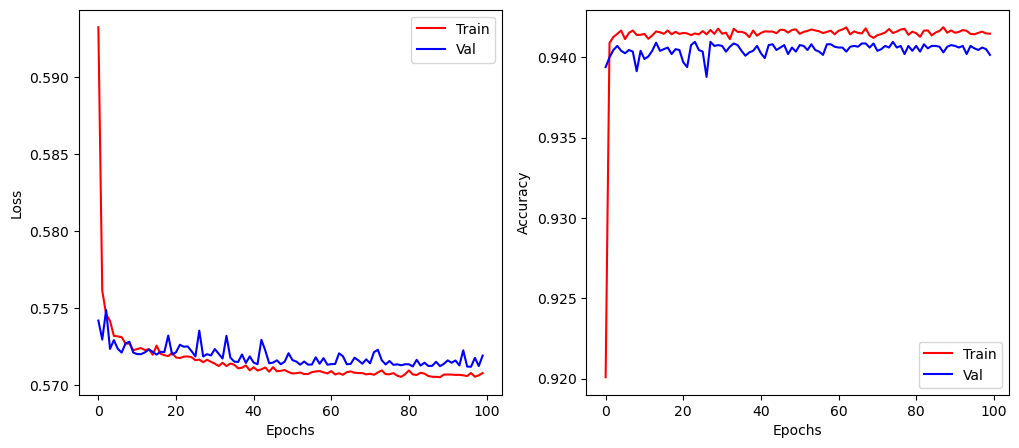

In [174]:
plot_training(losses, accuracies)

Размер проверочного датасета: 8442
Accuracy: 0.938522
ROC-AUC: 0.938988
F1 Score: 0.835603
Precision: 0.852067
Recall: 0.819764


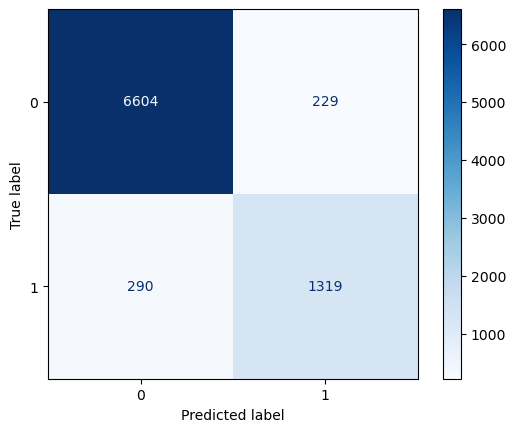

In [195]:
nn_model.eval()
with torch.no_grad():
    pred_proba = nn_model(X_test_tensor).numpy()
predictions = np.array([1 if pred > 0.5 else 0 for pred in pred_proba])
show_metrics(y_test, predictions, pred_proba)

In [177]:
submission_preds, _ = stacking_predict(submission_df, models, nn_model)

In [180]:
submit_predictions(submission_preds, filename='catboost_cut_dataset_stackingNN')

Файл catboost_cut_dataset_stackingNN.csv сохранен.


**Public score:  0.94093**

**Private score: 0.94012**

In [179]:
torch.save(nn_model.state_dict(), 'cb_stacking/nn_model_cut_dataset.pth')

#### CatBoostCV + Нейронная сеть (стекинг)

Для кросс-валидации будем использовать 5 фолдов на каждом наборе.

In [207]:
params = {
    "iterations": 800,
    "learning_rate": 0.0425,
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    "bagging_temperature": 1,
    "random_strength": 4,
    "l2_leaf_reg": 4,
    "early_stopping_rounds": 150,
    "verbose": 100
}
cv_models = []
for i in range(len(datasets)):
    print(f'Training {i+1} model:')
    train_val_pool = Pool(data=datasets[i], label=balanced_df_labels[i], cat_features=cat_cols)
    models = cv(
        params=params,
        pool=train_val_pool,
        fold_count=5,                
        partition_random_seed=156,    
        stratified=True,             
        verbose=False,
        seed=56,
        plot=False,
        return_models=True
    )

    cv_models.append(models[1])

cv_models = [item for sublist in cv_models for item in sublist]

Training 1 model:
Training on fold [0/5]

bestTest = 0.9241444073
bestIteration = 432

Training on fold [1/5]

bestTest = 0.9226836394
bestIteration = 574

Training on fold [2/5]

bestTest = 0.9245617696
bestIteration = 270

Training on fold [3/5]

bestTest = 0.9216238781
bestIteration = 192

Training on fold [4/5]

bestTest = 0.9219369651
bestIteration = 202

Training 2 model:
Training on fold [0/5]

bestTest = 0.920596828
bestIteration = 423

Training on fold [1/5]

bestTest = 0.9185100167
bestIteration = 262

Training on fold [2/5]

bestTest = 0.9249791319
bestIteration = 342

Training on fold [3/5]

bestTest = 0.9224587769
bestIteration = 431

Training on fold [4/5]

bestTest = 0.9227718639
bestIteration = 387

Training 3 model:
Training on fold [0/5]

bestTest = 0.9186143573
bestIteration = 318

Training on fold [1/5]

bestTest = 0.9207011686
bestIteration = 169

Training on fold [2/5]

bestTest = 0.9214315526
bestIteration = 216

Training on fold [3/5]

bestTest = 0.920997704
bes

In [222]:
for i in range(len(cv_models)):
    cv_models[i] = catboost.to_classifier(cv_models[i])
len(cv_models)

25

In [223]:
catboost_cv_features = np.zeros((df.shape[0], len(cv_models)))
for i, model in enumerate(cv_models):
    catboost_cv_features[:, i] = model.predict_proba(df)[:, 1]

X_train, X_test_val, y_train, y_test_val = train_test_split(catboost_cv_features, labels, test_size=0.20, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.3, random_state=65)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print(f'Размер train: {len(y_train)}, размер val: {len(y_val)}, размер test: {len(y_test)}')

Размер train: 112560, размер val: 19698, размер test: 8442


In [225]:
nn_model = StackingNN(input_dim=X_train.shape[1], hidden_dim=80) 
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 512 #37520 #56280 #16384
scheduler_step_size = 20
scheduler_gamma = 0.75
losses, accuracies = train_nn_model(nn_model, optimizer, criterion,
                                    X_train_tensor, y_train_tensor,
                                    X_val_tensor, y_val_tensor,
                                    n_epochs=n_epochs, batch_size=batch_size,
                                    scheduler_step_size=scheduler_step_size, 
                                    scheduler_gamma=scheduler_gamma)


Epoch 1/100, Train Loss: 0.5892, Train Acc: 0.9326, Val Acc: 0.9385, lr: 0.001000
Epoch 2/100, Train Loss: 0.5760, Train Acc: 0.9404, Val Acc: 0.9391, lr: 0.001000
Epoch 3/100, Train Loss: 0.5757, Train Acc: 0.9405, Val Acc: 0.9398, lr: 0.001000
Epoch 4/100, Train Loss: 0.5757, Train Acc: 0.9406, Val Acc: 0.9392, lr: 0.001000
Epoch 5/100, Train Loss: 0.5743, Train Acc: 0.9407, Val Acc: 0.9394, lr: 0.001000
Epoch 6/100, Train Loss: 0.5746, Train Acc: 0.9403, Val Acc: 0.9393, lr: 0.001000
Epoch 7/100, Train Loss: 0.5740, Train Acc: 0.9407, Val Acc: 0.9400, lr: 0.001000
Epoch 8/100, Train Loss: 0.5744, Train Acc: 0.9405, Val Acc: 0.9394, lr: 0.001000
Epoch 9/100, Train Loss: 0.5741, Train Acc: 0.9403, Val Acc: 0.9391, lr: 0.001000
Epoch 10/100, Train Loss: 0.5736, Train Acc: 0.9404, Val Acc: 0.9400, lr: 0.001000
Epoch 11/100, Train Loss: 0.5738, Train Acc: 0.9402, Val Acc: 0.9394, lr: 0.001000
Epoch 12/100, Train Loss: 0.5739, Train Acc: 0.9405, Val Acc: 0.9397, lr: 0.001000
Epoch 13/100,

In [226]:
nn_model

StackingNN(
  (fc1): Linear(in_features=25, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
)

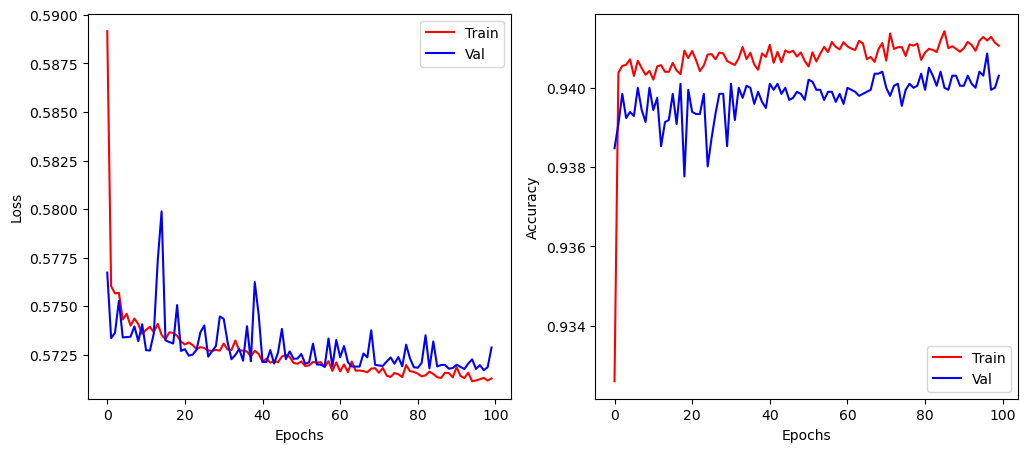

In [227]:
plot_training(losses, accuracies)

Размер проверочного датасета: 8442
Accuracy: 0.938522
ROC-AUC: 0.965784
F1 Score: 0.835290
Precision: 0.853437
Recall: 0.817899


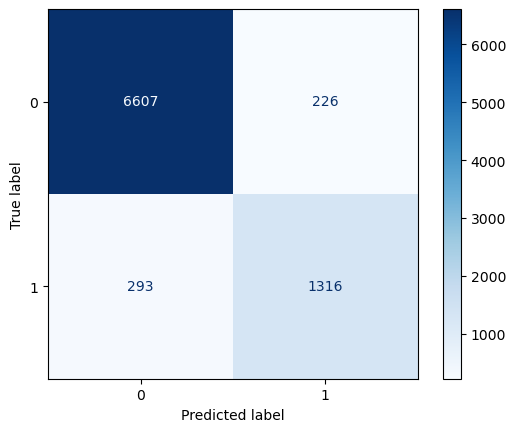

In [228]:
nn_model.eval()
with torch.no_grad():
    pred_proba = nn_model(X_test_tensor).numpy()
predictions = np.array([1 if pred > 0.5 else 0 for pred in pred_proba])

show_metrics(y_test, predictions, pred_proba)

In [230]:
submission_preds, _ = stacking_predict(submission_df, cv_models, nn_model)
submit_predictions(submission_preds, filename='catboost_cv5_cut_dataset_stackingNN')

Файл catboost_cv5_cut_dataset_stackingNN.csv сохранен.


**Public score:  0.94136**

**Private score: 0.94025**

In [231]:
torch.save(nn_model.state_dict(), 'cb_stacking/nn_model_cv5_cut_dataset.pth')

# Light GBM

In [232]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [243]:
df = pd.read_csv('processed_train.csv')
target = 'Depression'
labels = df[target]
df.drop(target, axis=1, inplace=True)
num_cols = list(df.select_dtypes(include=[int, float]).columns)
cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)
df[cat_cols] = df[cat_cols].astype('category')

In [244]:
X_train, X_test_val, y_train, y_test_val = train_test_split(df, labels, test_size=0.20, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.3, random_state=65)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature='auto')
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, categorical_feature='auto')
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')

print(f'Размер train-части: {len(y_train)}\nРазмер val-части:   {len(y_val)}\nРазмер test-части:  {len(y_test)}')

Размер train-части: 112560
Размер val-части:   19698
Размер test-части:  8442


## Классический LightGBM

#### LightGBM: Gradien Boosting Decision Trees

[LightGBM] [Info] Number of positive: 20377, number of negative: 92183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181032 -> initscore=-1.509369
[LightGBM] [Info] Start training from score -1.509369
Размер проверочного датасета: 8442
Accuracy: 0.938048
ROC-AUC: 0.974762
F1 Score: 0.832533
Precision: 0.858653
Recall: 0.807955


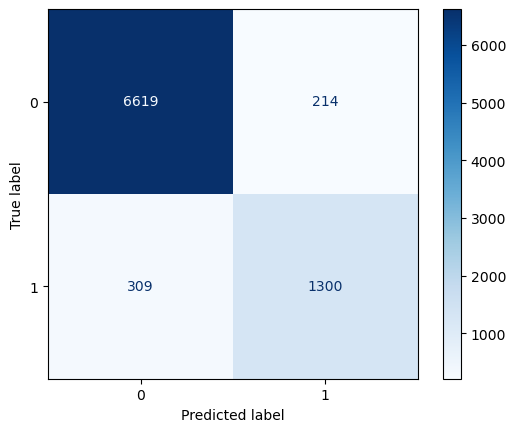

In [246]:
params = {
    'objective': 'binary', 
    'metric': 'accuracy',
    'boosting_type': 'gbdt', 
    'learning_rate': 0.05,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.8,
    'bagging_freq': 7,
    'verbose': 1,
    'random_state': 56,
    'n_jobs': -1
}

num_boost_round = 1000
model = lgb.train(params, train_data, num_boost_round, 
                  valid_sets=[val_data])


y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]

show_metrics(y_test, y_pred, y_pred_proba)

In [249]:
y_pred_proba = model.predict(submission_df, num_iteration=model.best_iteration)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]
submit_predictions(y_pred, filename='lightgbm_gbdt')

Файл lightgbm_gbdt.csv сохранен.


**Public score:  0.93987**

**Private score: 0.93903**

#### LightGBM: Random Forest

[LightGBM] [Info] Number of positive: 20377, number of negative: 92183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181032 -> initscore=-1.509369
[LightGBM] [Info] Start training from score -1.509369
Размер проверочного датасета: 8442
Accuracy: 0.930230
ROC-AUC: 0.968928
F1 Score: 0.818041
Precision: 0.813268
Recall: 0.822871


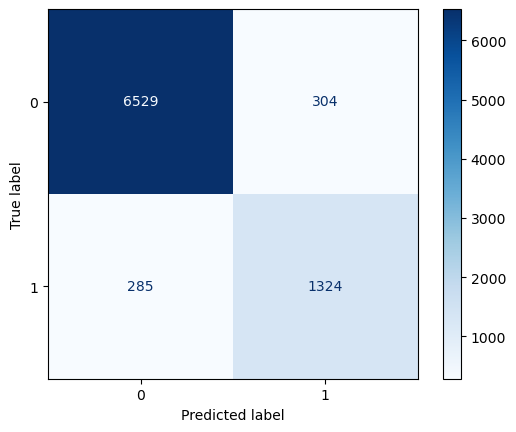

In [291]:
params = {
    'objective': 'binary', 
    'metric': 'accuracy',
    'boosting_type': 'rf',
    'learning_rate': 0.04,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.05,
    'bagging_freq': 8,
    'verbose': 1,
    'random_state': 56,
    'n_jobs': -1
}

num_boost_round = 1000
model = lgb.train(params, train_data, num_boost_round, 
                  valid_sets=[val_data])

y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]

show_metrics(y_test, y_pred, y_pred_proba)

In [292]:
y_pred_proba = model.predict(submission_df, num_iteration=model.best_iteration)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]
submit_predictions(y_pred, filename='lightgbm_rf')

Файл lightgbm_rf.csv сохранен.


**Public score:  0.93192**

**Private score: 0.93154**

## CV LightGBM

In [294]:
df = pd.read_csv('processed_train.csv')
df[cat_cols] = df[cat_cols].astype('category')

train, val_test = train_test_split(df, test_size=0.20, random_state=56)
val, test = train_test_split(val_test, test_size=0.3, random_state=65)

train_val = pd.concat([train, val])
y_train_val = train_val[target]
X_train_val = train_val.drop(target, axis=1)
print(f'Размер train-части: {len(train)}\nРазмер val-части:   {len(val)}\nРазмер test-части:  {len(test)}')

Размер train-части: 112560
Размер val-части:   19698
Размер test-части:  8442


In [297]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=556)
lgb_gbdt_models = []
oof_preds = np.zeros(len(labels))  # Out-of-fold прогнозы
print('LightGBM - gradien boosting model')
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    lgb_params = {
        'objective': 'binary',
        'metric': 'accuracy',
        'boosting_type': 'gbdt',
        'feature_fraction': 0.4,
        'bagging_fraction': 0.8,
      #  'bagging_freq': 12,
    #    'learning_rate': 0.05,
        'n_estimators': 300,
        'verbose': -1
    }
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='accuracy',
    )
    lgb_gbdt_models.append(lgb_model)
    
    y_pred_proba = lgb_model.predict(X_val)#, num_iteration=model.best_iteration)
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]
    
    acc = accuracy_score(y_val, y_pred)
    print(f'Fold {fold + 1}: Accuracy: {acc:.5f}')


LightGBM - gradien boosting model
Fold 1: Accuracy: 0.93902
Fold 2: Accuracy: 0.93660
Fold 3: Accuracy: 0.93864
Fold 4: Accuracy: 0.94238
Fold 5: Accuracy: 0.93868


In [298]:

lgb_dart_models = []
oof_preds = np.zeros(len(labels))  # Out-of-fold прогнозы
print('LightGBM - dart model')
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    lgb_params = {
        'objective': 'binary',
        'metric': 'accuracy',
        'boosting_type': 'dart',
      #  'feature_fraction': 0.7,
        'bagging_fraction': 0.8,
        'bagging_freq': 4,
       # 'learning_rate': 0.05,
        'n_estimators': 250,
        'verbose': -1,
        'n_jobs': -1
    }
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='accuracy',
    )
    lgb_dart_models.append(lgb_model)
    
    y_pred_proba = lgb_model.predict(X_val)# num_iteration=model.best_iteration)
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_proba]
    
    acc = accuracy_score(y_val, y_pred)
    print(f'Fold {fold + 1}: Accuracy: {acc:.5f}')



LightGBM - dart model
Fold 1: Accuracy: 0.93849
Fold 2: Accuracy: 0.93596
Fold 3: Accuracy: 0.93842
Fold 4: Accuracy: 0.94269
Fold 5: Accuracy: 0.93804


In [309]:
len(lgb_gbdt_models)

5

In [308]:
len(lgb_dart_models)

5

In [311]:
gbdt_dart_models = lgb_gbdt_models + lgb_dart_models
len(gbdt_dart_models)

10

Размер проверочного датасета: 8442
Accuracy: 0.937811
F1 Score: 0.831892
Precision: 0.857992
Recall: 0.807334


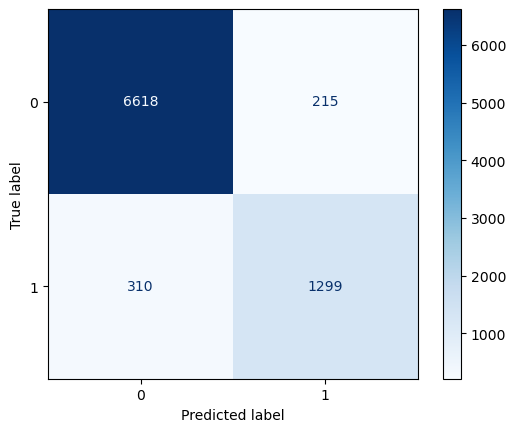

In [319]:
y_test = test[target]
X_test = test.drop(target, axis=1)
cv_ensemble_preds = majority_vote_with_metrics(gbdt_dart_models, X_test, y_test, lgbm=True)

In [320]:
y_pred_proba = np.array([lgb_model.predict(submission_df) for model in gbdt_dart_models])
y_pred = np.array([[1 if pred >= 0.5 else 0 for pred in subarr] for subarr in y_pred_proba])
y_pred = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=y_pred)
submit_predictions(y_pred, filename='lightgbm_cv5_gbdt_dart_majorityVote')

Файл lightgbm_cv5_gbdt_dart_majorityVote.csv сохранен.


**Public score:  0.94035**

**Private score: 0.93947**

# Catboost + LightGBM + NN

In [327]:
df = pd.read_csv('processed_train.csv')
target = 'Depression'
labels = df[target]
df.drop(target, axis=1, inplace=True)
num_cols = list(df.select_dtypes(include=[int, float]).columns)
cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)
df[cat_cols] = df[cat_cols].astype('category')

In [322]:
import os
catboost_info_path = "catboost_info_cv5"
fold_paths = [os.path.join(catboost_info_path, folder) 
              for folder in os.listdir(catboost_info_path) 
              if folder.startswith("fold-")]

catboost_cv_models = []
for fold_path in fold_paths:
    model_path = os.path.join(fold_path, "model")  #
    if os.path.exists(model_path):
        model = CatBoostClassifier()
        model.load_model(model_path)
        catboost_cv_models.append(model)
print(f"Загружено моделей: {len(catboost_cv_models)}")

Загружено моделей: 5


In [328]:
# Прогнозы моделей для всех данных
cb_features = np.zeros((df.shape[0], len(catboost_cv_models)))
for i, model in enumerate(catboost_cv_models):
    cb_features[:, i] = model.predict_proba(df)[:, 1]

lgb_gbdt_features = np.zeros((df.shape[0], len(lgb_gbdt_models)))
for i, model in enumerate(lgb_gbdt_models):
    lgb_gbdt_features[:, i] = model.predict_proba(df)[:, 1]

lgb_dart_features = np.zeros((df.shape[0], len(lgb_dart_models)))
for i, model in enumerate(lgb_dart_models):
    lgb_dart_features[:, i] = model.predict_proba(df)[:, 1]

stacking_features = np.hstack([lgb_gbdt_features, lgb_dart_features, cb_features])

In [329]:
stacking_features.shape

(140700, 15)

Архитектура сети аналогична той, что применялась в ансамбле с CatBoost

In [330]:
class StackingNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(StackingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(p=0.1)
        self.activation = nn.GELU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        return self.sigmoid(x)

In [331]:
X_train, X_test_val, y_train, y_test_val = train_test_split(stacking_features, labels, test_size=0.20, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.3, random_state=65)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print(f'Размер train: {len(y_train)}, размер val: {len(y_val)}, размер test: {len(y_test)}')

Размер train: 112560, размер val: 19698, размер test: 8442


In [336]:
nn_model = StackingNN(input_dim=X_train.shape[1], hidden_dim=64) 
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.0005)

n_epochs = 50
batch_size = 1024 #37520 #56280 #16384
scheduler_step_size = 20
scheduler_gamma = 0.75
losses, accuracies = train_nn_model(nn_model, optimizer, criterion,
                                    X_train_tensor, y_train_tensor,
                                    X_val_tensor, y_val_tensor,
                                    n_epochs=n_epochs, batch_size=batch_size,
                                    scheduler_step_size=scheduler_step_size, 
                                    scheduler_gamma=scheduler_gamma)


Epoch 1/50, Train Loss: 0.6134, Train Acc: 0.9072, Val Acc: 0.9461, lr: 0.000500
Epoch 2/50, Train Loss: 0.5652, Train Acc: 0.9483, Val Acc: 0.9485, lr: 0.000500
Epoch 3/50, Train Loss: 0.5628, Train Acc: 0.9508, Val Acc: 0.9516, lr: 0.000500
Epoch 4/50, Train Loss: 0.5609, Train Acc: 0.9535, Val Acc: 0.9545, lr: 0.000500
Epoch 5/50, Train Loss: 0.5592, Train Acc: 0.9559, Val Acc: 0.9559, lr: 0.000500
Epoch 6/50, Train Loss: 0.5574, Train Acc: 0.9579, Val Acc: 0.9575, lr: 0.000500
Epoch 7/50, Train Loss: 0.5562, Train Acc: 0.9592, Val Acc: 0.9600, lr: 0.000500
Epoch 8/50, Train Loss: 0.5554, Train Acc: 0.9597, Val Acc: 0.9604, lr: 0.000500
Epoch 9/50, Train Loss: 0.5550, Train Acc: 0.9601, Val Acc: 0.9593, lr: 0.000500
Epoch 10/50, Train Loss: 0.5541, Train Acc: 0.9605, Val Acc: 0.9610, lr: 0.000500
Epoch 11/50, Train Loss: 0.5537, Train Acc: 0.9610, Val Acc: 0.9612, lr: 0.000500
Epoch 12/50, Train Loss: 0.5532, Train Acc: 0.9611, Val Acc: 0.9612, lr: 0.000500
Epoch 13/50, Train Loss: 

In [337]:
nn_model

StackingNN(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
)

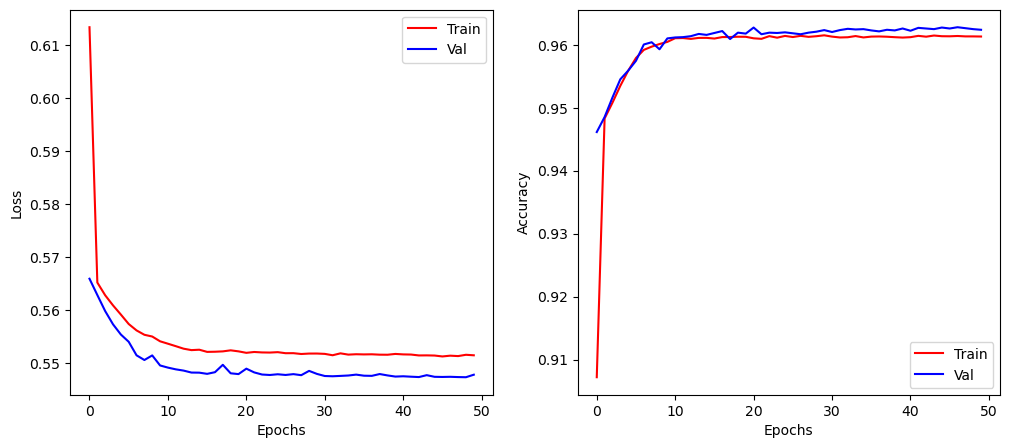

In [338]:
plot_training(losses, accuracies)

Размер проверочного датасета: 8442
Accuracy: 0.928216
ROC-AUC: 0.950383
F1 Score: 0.805894
Precision: 0.831461
Recall: 0.781852


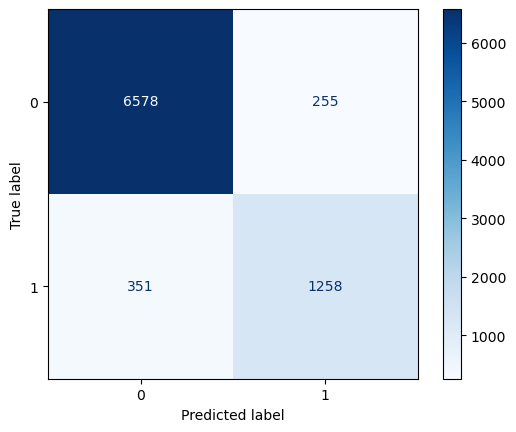

In [339]:
nn_model.eval()
with torch.no_grad():
    pred_proba = nn_model(X_test_tensor).numpy()
predictions = np.array([1 if pred > 0.5 else 0 for pred in pred_proba])

show_metrics(y_test, predictions, pred_proba)

In [340]:

cb_features = np.zeros((submission_df.shape[0], len(catboost_cv_models)))
for i, model in enumerate(catboost_cv_models):
    cb_features[:, i] = model.predict_proba(submission_df)[:, 1]

lgb_gbdt_features = np.zeros((submission_df.shape[0], len(lgb_gbdt_models)))
for i, model in enumerate(lgb_gbdt_models):
    lgb_gbdt_features[:, i] = model.predict_proba(submission_df)[:, 1]

lgb_dart_features = np.zeros((submission_df.shape[0], len(lgb_dart_models)))
for i, model in enumerate(lgb_dart_models):
    lgb_dart_features[:, i] = model.predict_proba(submission_df)[:, 1]

submission_features = np.hstack([lgb_gbdt_features, lgb_dart_features, cb_features])
submission_features.shape

(93800, 15)

In [342]:
submission_features_tensor = torch.tensor(submission_features, dtype=torch.float32)
nn_model.eval()
with torch.no_grad():
    pred_proba = nn_model(submission_features_tensor).numpy()
submission_preds = np.array([1 if pred > 0.5 else 0 for pred in pred_proba])
submit_predictions(submission_preds, filename='cb_lgbm_stackingNN')

Файл cb_lgbm_stackingNN.csv сохранен.


**Public score:  0.93432**

**Private score: 0.93074**

In [359]:
metrics = {
    'Классический CatBoost': 0.94027,
    'CatBoostCV_5 MajorityVote': 0.94031,
    'CatBoostCV_10 MajorityVote': 0.94023,
    'CatBoostCV_20 MajorityVote': 0.94007,
    'CatBoostCV_5 + NN': 0.94051,
    'CatBoostCV_10 + NN': 0.93908, 
    'BalancedClasses CB + NN': 0.94012,
    'BalancedClasses CB_CV5 + NN': 0.94025,
    'LightGBM: GBDT': 0.93903,
    'LightGBM: RF': 0.93154,
    'LightGBM_CV5: GBDT + Dart': 0.93947,
    'CB + LGBM + NN': 0.93074
}

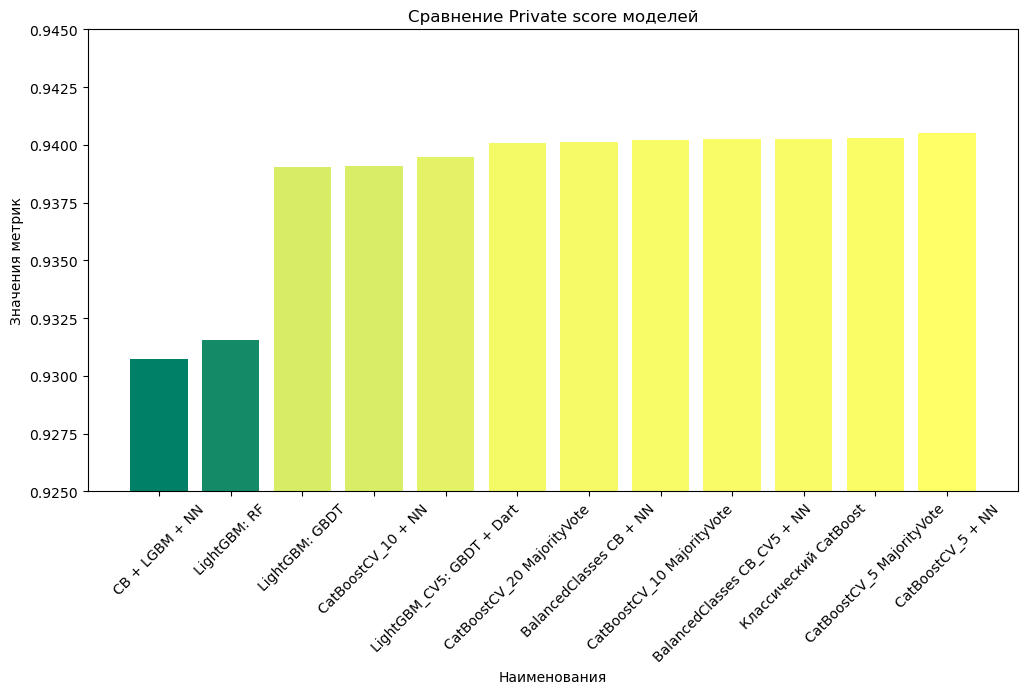

In [362]:
import matplotlib.cm as cm
sorted_metrics = dict(sorted(metrics.items(), key=lambda item: item[1]))

labels = list(sorted_metrics.keys())
values = list(sorted_metrics.values())
norm = plt.Normalize(min(values), max(values))
colors = cm.summer(norm(values))

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color=colors)

plt.title('Столбчатый график метрик')
plt.xlabel('Наименования')
plt.ylabel('Значения метрик')
plt.ylim(0.925, 0.945)
plt.xticks(rotation=45)

plt.title(f'Сравнение Private score моделей')

plt.show()